# Querying the Human Lung Cell Atlas

Here we demonstrate how to query the Human Lung Cell Atlas using scANVI, scArches, and scvi-hub.

- Sikkema, Lisa, et al. "An integrated cell atlas of the human lung in health and disease." [bioRxiv](https://www.biorxiv.org/content/10.1101/2022.03.10.483747v1) (2022).

If you use this tutorial in your research we recommend citing the HLCA as well as scANVI, scArches, and scvi-tools, which can be found on the [references page](https://docs.scvi-tools.org/en/stable/references.html) at Gayoso22, Lotfollahi21, Xu21 respectively.

This tutorial is adapted from a [similar one](https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/blob/main/notebooks/LCA_scArches_mapping_new_data_to_hlca.ipynb) presented by the HLCA authors.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/env/lib/python3.11/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile

import anndata
import numba
import numpy as np
import pandas as pd
import pooch
import pynndescent
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scvi.hub import HubModel
from scvi.model.utils import mde

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.0


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

## Download the reference files

First we download the pre-trained scANVI model from the HuggingFace [repo](https://huggingface.co/scvi-tools/human-lung-cell-atlas).

In [5]:
hubmodel = HubModel.pull_from_huggingface_hub(
    "scvi-tools/human-lung-cell-atlas", cache_dir=save_dir.name
)
adata = hubmodel.adata
model = hubmodel.model

/tmp/ipykernel_158/600709524.py:1: UserWarning: No revision was passed, so the default (latest) revision will be used.
  hubmodel = HubModel.pull_from_huggingface_hub(


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

_scvi_required_metadata.json:   0%|          | 0.00/247 [00:00<?, ?B/s]

adata.h5ad:   0%|          | 0.00/905M [00:00<?, ?B/s]

model.pt:   0%|          | 0.00/5.83M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.46k [00:00<?, ?B/s]

INFO     Reading adata...                                                                                          


INFO     Loading model...                                                                                          


INFO     File                                                                                                      
         /tmp/tmpmw6gbji7/models--scvi-tools--human-lung-cell-atlas/snapshots/7af8f610b2c46b715e62cf46bc14163d8a3e6
         79e/model.pt already downloaded                                                                           


/env/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



/env/lib/python3.11/site-packages/scvi/data/fields/_dataframe_field.py:221: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/env/lib/python3.11/site-packages/scvi/data/fields/_scanvi.py:56: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


In [6]:
adata

AnnData object with n_obs × n_vars = 584944 × 2000
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', 'o

In [7]:
model

ScanVI Model with the following params: 
unlabeled_category: unlabeled, n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: nb
Training status: Trained
Model's adata is minified?: True

In [8]:
model.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.0.

Setup via `SCANVI.setup_anndata` with arguments:

{
│   'labels_key': 'scanvi_label',
│   'unlabeled_category': 'unlabeled',
│   'layer': None,
│   'batch_key': 'dataset',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   14   │
│         n_cells          │ 584944 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   29   │
│       n_latent_qzm       │   30   │
│       n_latent_qzv       │   30   │
│          n_vars          │  2000  │
└──────────────────────────┴────────┘

                        Data Registry                         
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Registry Key    ┃          scvi-tools Location           ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         X         │                adata.X                 │
│       batch       │        adata.obs['_scvi_batch']        │
│      labels       │       adata.obs['_scvi_labels']        │
│    latent_qzm     │    adata.obsm['_scanvi_latent_qzm']    │
│    latent_qzv     │    adata.obsm['_scanvi_latent_qzv']    │
│    minify_type    │  adata.uns['_scvi_adata_minify_type']  │
│ observed_lib_size │ adata.obs['_scanvi_observed_lib_size'] │
└───────────────────┴────────────────────────────────────────┘

                           batch State Registry                           
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location    ┃        Categories         ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['dataset'] │   Banovich_Kropski_2020   │          0          │
│                      │     Barbry_Leroy_2020     │          1          │
│                      │ Jain_Misharin_2021_10Xv1  │          2          │
│                      │ Jain_Misharin_2021_10Xv2  │          3          │
│                      │       Krasnow_2020        │          4          │
│                      │ Lafyatis_Rojas_2019_10Xv1 │          5          │
│                      │ Lafyatis_Rojas_2019_10Xv2 │          6          │
│                      │        Meyer_2019         │          7          │
│                      │       Misharin_2021       │          8          │
│                      │  Misharin_Budinger_2018   │          9          │
│                      │        Nawijn_2021        │         10          │
│                      │    Seibold_2020_10Xv2     │         11          │
│                      │    Seibold_2020_10Xv3     │         12          │
│                      │   Teichmann_Meyer_2019    │         13          │
└──────────────────────┴───────────────────────────┴─────────────────────┘

                            labels State Registry                            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃       Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['scanvi_label'] │           AT1           │          0          │
│                           │           AT2           │          1          │
│                           │       Arterial EC       │          2          │
│                           │     B cell lineage      │          3          │
│                           │          Basal          │          4          │
│                           │   Bronchial Vessel 1    │          5          │
│                           │   Bronchial Vessel 2    │          6          │
│                           │        Capillary        │          7          │
│                           │        Ciliated         │          8          │
│                           │     Dendritic cells     │          9          │
│                           │   Fibroblast lineage    │         10          │
│                           │ KRT5- KRT17+ epithelial │         11          │
│                           │      Lymphatic EC       │         12          │
│                           │       Macrophages       │         13          │
│                           │       Mast cells        │         14          │
│                           │     Megakaryocytes      │         15          │
│                           │       Mesothelium       │         16          │
│                           │        Monocytes        │         17          │
│                           │      Neutrophilic       │         18          │
│                           │      Non-T/B cells      │         19          │
│                           │   Proliferating cells   │         20          │
│                           │          Rare           │         21          │
│                           │        Secretory        │         22          │
│                           │      Smooth Muscle      │         23          │
│                           │        Squamous         │         24          │
│                           │  Submucosal Secretory   │         25          │
│                           │     T cell lineage      │         26          │
│                           │         Venous          │         27          │
│                           │        unlabeled        │         28          │
└───────────────────────────┴─────────────────────────┴─────────────────────┘

## Learn a neighbors index on reference latent space

Here we create the neighbors index using `PyNNDescent`. We will use this later to classify query cells. `PyNNDescent` is an extremely fast approximate neighbors technique.

In the case of the `HubModel` instance above, we see that the data is in minified mode, meaning the count data is not actually in the object, and we only store a minified representation of the data. We see that we can access the mean of the embedding (`latent_qzm`) above.

In [9]:
X_train = adata.obsm["_scanvi_latent_qzm"]
ref_nn_index = pynndescent.NNDescent(X_train)
ref_nn_index.prepare()

## Download query data

In this tutorial we use the fresh, single-cell sample from the following publication:

- Delorey, Toni M., et al. "COVID-19 tissue atlases reveal SARS-CoV-2 pathology and cellular targets." Nature 595.7865 (2021): 107-113.

In principle at this stage you may load your own data. There are few important notes though:

- Using the HLCA requires using Gene IDs for the query data
- The query data should include batches in `query_data.obs["dataset"]`
- It's necessary to run `query_data.obs["scanvi_label"] = "unlabeled"` so that scvi-tools can properly register the query data.

In [10]:
def download_data(save_path: str):
    """Download and cache the query data."""
    data_path = pooch.retrieve(
        url="https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5230nnn/GSM5230027/suppl/GSM5230027_04-P103142-S149-R01_raw_feature_bc_matrix.h5.gz",
        known_hash="3b7f8318059d655ea774752b6d8b13381323f5018e9f3868ffc53674f94f537f",
        fname="query_data.h5.gz",
        path=save_path,
        processor=pooch.Decompress(),
        progressbar=True,
    )
    metadata_path = pooch.retrieve(
        url="https://ftp.ncbi.nlm.nih.gov/geo/series/GSE171nnn/GSE171668/suppl/GSE171668_lung_metadata.csv.gz",
        known_hash="290b0ac86e85183e65eefb68670ad27fc5156866144d9ac6f2eb27f34e31e79e",
        fname="query_metadata.csv.gz",
        path=save_path,
        processor=pooch.Decompress(),
        progressbar=True,
    )
    return data_path, metadata_path

In [11]:
query_data_path, query_metadata_path = download_data(save_dir.name)

query_adata = sc.read_10x_h5(query_data_path)
query_metadata = pd.read_csv(query_metadata_path, index_col=0)

  0%|                                              | 0.00/27.4M [00:00<?, ?B/s]

  0%|                                      | 33.8k/27.4M [00:00<01:43, 265kB/s]

  1%|▎                                      | 214k/27.4M [00:00<00:29, 925kB/s]

  3%|█▎                                    | 902k/27.4M [00:00<00:08, 2.94MB/s]

 12%|████▍                                | 3.33M/27.4M [00:00<00:02, 8.73MB/s]

 24%|████████▊                            | 6.54M/27.4M [00:00<00:01, 14.9MB/s]

 29%|██████████▉                          | 8.06M/27.4M [00:00<00:01, 11.5MB/s]

 38%|█████████████▉                       | 10.3M/27.4M [00:00<00:01, 13.6MB/s]

 44%|████████████████▏                    | 12.0M/27.4M [00:01<00:01, 13.4MB/s]

 50%|██████████████████▍                  | 13.6M/27.4M [00:01<00:01, 13.3MB/s]

 56%|████████████████████▋                | 15.3M/27.4M [00:01<00:00, 13.3MB/s]

 62%|██████████████████████▉              | 17.0M/27.4M [00:01<00:00, 13.2MB/s]

 68%|█████████████████████████▏           | 18.7M/27.4M [00:01<00:00, 13.5MB/s]

 74%|███████████████████████████▍         | 20.3M/27.4M [00:01<00:00, 14.3MB/s]

 80%|█████████████████████████████▍       | 21.8M/27.4M [00:01<00:00, 13.7MB/s]

 85%|███████████████████████████████▎     | 23.2M/27.4M [00:01<00:00, 13.0MB/s]

 90%|█████████████████████████████████▎   | 24.6M/27.4M [00:02<00:00, 13.2MB/s]

 96%|███████████████████████████████████▌ | 26.3M/27.4M [00:02<00:00, 14.2MB/s]

  0%|                                              | 0.00/27.4M [00:00<?, ?B/s]

100%|█████████████████████████████████████| 27.4M/27.4M [00:00<00:00, 70.7GB/s]


Decompressing '/tmp/tmpmw6gbji7/query_data.h5.gz' to '/tmp/tmpmw6gbji7/query_data.h5.gz.decomp' using method 'auto'.


  0%|                                              | 0.00/1.95M [00:00<?, ?B/s]

  2%|▋                                     | 33.8k/1.95M [00:00<00:07, 267kB/s]

 10%|███▉                                   | 198k/1.95M [00:00<00:02, 869kB/s]

 31%|███████████▊                          | 607k/1.95M [00:00<00:00, 2.11MB/s]

 61%|██████████████████████▍              | 1.18M/1.95M [00:00<00:00, 3.10MB/s]

 98%|████████████████████████████████████▍| 1.92M/1.95M [00:00<00:00, 2.46MB/s]

  0%|                                              | 0.00/1.95M [00:00<?, ?B/s]

100%|█████████████████████████████████████| 1.95M/1.95M [00:00<00:00, 6.47GB/s]


Decompressing '/tmp/tmpmw6gbji7/query_metadata.csv.gz' to '/tmp/tmpmw6gbji7/query_metadata.csv.gz.decomp' using method 'auto'.


/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [12]:
# clean up .var.index (gene names)
query_adata.var["gene_names"] = query_adata.var.index
query_adata.var.index = [idx.split("___")[-1] for idx in query_adata.var.gene_ids]
# clean up cell barcodes:
query_adata.obs.index = query_adata.obs.index.str.rstrip("-1")
# read in metadata (to select only cells of interest and remove empty drops)
# subset to cells from our sample
query_metadata = query_metadata.loc[query_metadata.donor == "D12_4", :].copy()
# clean up barcodes:
query_metadata.index = [idx.split("-")[-1] for idx in query_metadata.index]
# subset adata to cells in metadata:
query_adata = query_adata[query_metadata.index, :].copy()
# add dataset information:
query_adata.obs["dataset"] = "test_dataset_delorey_regev"

## Loading the query model from the reference files

Here we run `prepare_query_anndata`, which reorders the genes and pads any missing genes with 0s. This should generally be run before reference mapping with scArches to ensure data correctness.

```{important}
Below we use the path to the model we downloaded from HuggingFace. While in most cases the model instance can be used instead of the path, here the reference model's adata is in minified mode.
```

In [13]:
scvi.model.SCANVI.prepare_query_anndata(query_adata, model)

INFO     Found 99.65% reference vars in query data.                                                                


From above, we see that the model is expecting a labels key with the name `"scanvi_label"`.

In [14]:
query_adata.obs["scanvi_label"] = "unlabeled"

In [15]:
query_model = scvi.model.SCANVI.load_query_data(query_adata, model)

Here we use scArches/scANVI-specific query training arguments.

In [16]:
surgery_epochs = 500
train_kwargs_surgery = {
    "early_stopping": True,
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [17]:
query_model.train(max_epochs=surgery_epochs, **train_kwargs_surgery)

INFO     Training for 500 epochs.                                                                                  


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500:   0%|          | 1/500 [00:00<01:57,  4.26it/s]

Epoch 1/500:   0%|          | 1/500 [00:00<01:57,  4.26it/s, v_num=1, train_loss_step=464, train_loss_epoch=460]

Epoch 2/500:   0%|          | 1/500 [00:00<01:57,  4.26it/s, v_num=1, train_loss_step=464, train_loss_epoch=460]

Epoch 2/500:   0%|          | 2/500 [00:00<01:27,  5.71it/s, v_num=1, train_loss_step=464, train_loss_epoch=460]

Epoch 2/500:   0%|          | 2/500 [00:00<01:27,  5.71it/s, v_num=1, train_loss_step=450, train_loss_epoch=460]

Epoch 3/500:   0%|          | 2/500 [00:00<01:27,  5.71it/s, v_num=1, train_loss_step=450, train_loss_epoch=460]

Epoch 3/500:   1%|          | 3/500 [00:00<01:17,  6.42it/s, v_num=1, train_loss_step=450, train_loss_epoch=460]

Epoch 3/500:   1%|          | 3/500 [00:00<01:17,  6.42it/s, v_num=1, train_loss_step=457, train_loss_epoch=459]

Epoch 4/500:   1%|          | 3/500 [00:00<01:17,  6.42it/s, v_num=1, train_loss_step=457, train_loss_epoch=459]

Epoch 4/500:   1%|          | 4/500 [00:00<01:12,  6.83it/s, v_num=1, train_loss_step=457, train_loss_epoch=459]

Epoch 4/500:   1%|          | 4/500 [00:00<01:12,  6.83it/s, v_num=1, train_loss_step=447, train_loss_epoch=460]

Epoch 5/500:   1%|          | 4/500 [00:00<01:12,  6.83it/s, v_num=1, train_loss_step=447, train_loss_epoch=460]

Epoch 5/500:   1%|          | 5/500 [00:00<01:09,  7.08it/s, v_num=1, train_loss_step=447, train_loss_epoch=460]

Epoch 5/500:   1%|          | 5/500 [00:00<01:09,  7.08it/s, v_num=1, train_loss_step=432, train_loss_epoch=459]

Epoch 6/500:   1%|          | 5/500 [00:00<01:09,  7.08it/s, v_num=1, train_loss_step=432, train_loss_epoch=459]

Epoch 6/500:   1%|          | 6/500 [00:00<01:08,  7.24it/s, v_num=1, train_loss_step=432, train_loss_epoch=459]

Epoch 6/500:   1%|          | 6/500 [00:00<01:08,  7.24it/s, v_num=1, train_loss_step=435, train_loss_epoch=458]

Epoch 7/500:   1%|          | 6/500 [00:00<01:08,  7.24it/s, v_num=1, train_loss_step=435, train_loss_epoch=458]

Epoch 7/500:   1%|▏         | 7/500 [00:01<01:07,  7.34it/s, v_num=1, train_loss_step=435, train_loss_epoch=458]

Epoch 7/500:   1%|▏         | 7/500 [00:01<01:07,  7.34it/s, v_num=1, train_loss_step=464, train_loss_epoch=459]

Epoch 8/500:   1%|▏         | 7/500 [00:01<01:07,  7.34it/s, v_num=1, train_loss_step=464, train_loss_epoch=459]

Epoch 8/500:   2%|▏         | 8/500 [00:01<01:06,  7.42it/s, v_num=1, train_loss_step=464, train_loss_epoch=459]

Epoch 8/500:   2%|▏         | 8/500 [00:01<01:06,  7.42it/s, v_num=1, train_loss_step=444, train_loss_epoch=458]

Epoch 9/500:   2%|▏         | 8/500 [00:01<01:06,  7.42it/s, v_num=1, train_loss_step=444, train_loss_epoch=458]

Epoch 9/500:   2%|▏         | 9/500 [00:01<01:05,  7.47it/s, v_num=1, train_loss_step=444, train_loss_epoch=458]

Epoch 9/500:   2%|▏         | 9/500 [00:01<01:05,  7.47it/s, v_num=1, train_loss_step=442, train_loss_epoch=458]

Epoch 10/500:   2%|▏         | 9/500 [00:01<01:05,  7.47it/s, v_num=1, train_loss_step=442, train_loss_epoch=458]

Epoch 10/500:   2%|▏         | 10/500 [00:01<01:05,  7.50it/s, v_num=1, train_loss_step=442, train_loss_epoch=458]

Epoch 10/500:   2%|▏         | 10/500 [00:01<01:05,  7.50it/s, v_num=1, train_loss_step=457, train_loss_epoch=458]

Epoch 11/500:   2%|▏         | 10/500 [00:01<01:05,  7.50it/s, v_num=1, train_loss_step=457, train_loss_epoch=458]

Epoch 11/500:   2%|▏         | 11/500 [00:01<01:04,  7.53it/s, v_num=1, train_loss_step=457, train_loss_epoch=458]

Epoch 11/500:   2%|▏         | 11/500 [00:01<01:04,  7.53it/s, v_num=1, train_loss_step=460, train_loss_epoch=457]

Epoch 12/500:   2%|▏         | 11/500 [00:01<01:04,  7.53it/s, v_num=1, train_loss_step=460, train_loss_epoch=457]

Epoch 12/500:   2%|▏         | 12/500 [00:01<01:04,  7.54it/s, v_num=1, train_loss_step=460, train_loss_epoch=457]

Epoch 12/500:   2%|▏         | 12/500 [00:01<01:04,  7.54it/s, v_num=1, train_loss_step=432, train_loss_epoch=457]

Epoch 13/500:   2%|▏         | 12/500 [00:01<01:04,  7.54it/s, v_num=1, train_loss_step=432, train_loss_epoch=457]

Epoch 13/500:   3%|▎         | 13/500 [00:01<01:04,  7.55it/s, v_num=1, train_loss_step=432, train_loss_epoch=457]

Epoch 13/500:   3%|▎         | 13/500 [00:01<01:04,  7.55it/s, v_num=1, train_loss_step=478, train_loss_epoch=458]

Epoch 14/500:   3%|▎         | 13/500 [00:01<01:04,  7.55it/s, v_num=1, train_loss_step=478, train_loss_epoch=458]

Epoch 14/500:   3%|▎         | 14/500 [00:01<01:04,  7.52it/s, v_num=1, train_loss_step=478, train_loss_epoch=458]

Epoch 14/500:   3%|▎         | 14/500 [00:01<01:04,  7.52it/s, v_num=1, train_loss_step=444, train_loss_epoch=457]

Epoch 15/500:   3%|▎         | 14/500 [00:01<01:04,  7.52it/s, v_num=1, train_loss_step=444, train_loss_epoch=457]

Epoch 15/500:   3%|▎         | 15/500 [00:02<01:04,  7.53it/s, v_num=1, train_loss_step=444, train_loss_epoch=457]

Epoch 15/500:   3%|▎         | 15/500 [00:02<01:04,  7.53it/s, v_num=1, train_loss_step=433, train_loss_epoch=456]

Epoch 16/500:   3%|▎         | 15/500 [00:02<01:04,  7.53it/s, v_num=1, train_loss_step=433, train_loss_epoch=456]

Epoch 16/500:   3%|▎         | 16/500 [00:02<01:04,  7.53it/s, v_num=1, train_loss_step=433, train_loss_epoch=456]

Epoch 16/500:   3%|▎         | 16/500 [00:02<01:04,  7.53it/s, v_num=1, train_loss_step=463, train_loss_epoch=456]

Epoch 17/500:   3%|▎         | 16/500 [00:02<01:04,  7.53it/s, v_num=1, train_loss_step=463, train_loss_epoch=456]

Epoch 17/500:   3%|▎         | 17/500 [00:02<01:04,  7.47it/s, v_num=1, train_loss_step=463, train_loss_epoch=456]

Epoch 17/500:   3%|▎         | 17/500 [00:02<01:04,  7.47it/s, v_num=1, train_loss_step=428, train_loss_epoch=456]

Epoch 18/500:   3%|▎         | 17/500 [00:02<01:04,  7.47it/s, v_num=1, train_loss_step=428, train_loss_epoch=456]

Epoch 18/500:   4%|▎         | 18/500 [00:02<01:04,  7.47it/s, v_num=1, train_loss_step=428, train_loss_epoch=456]

Epoch 18/500:   4%|▎         | 18/500 [00:02<01:04,  7.47it/s, v_num=1, train_loss_step=415, train_loss_epoch=455]

Epoch 19/500:   4%|▎         | 18/500 [00:02<01:04,  7.47it/s, v_num=1, train_loss_step=415, train_loss_epoch=455]

Epoch 19/500:   4%|▍         | 19/500 [00:02<01:04,  7.50it/s, v_num=1, train_loss_step=415, train_loss_epoch=455]

Epoch 19/500:   4%|▍         | 19/500 [00:02<01:04,  7.50it/s, v_num=1, train_loss_step=462, train_loss_epoch=456]

Epoch 20/500:   4%|▍         | 19/500 [00:02<01:04,  7.50it/s, v_num=1, train_loss_step=462, train_loss_epoch=456]

Epoch 20/500:   4%|▍         | 20/500 [00:02<01:03,  7.52it/s, v_num=1, train_loss_step=462, train_loss_epoch=456]

Epoch 20/500:   4%|▍         | 20/500 [00:02<01:03,  7.52it/s, v_num=1, train_loss_step=445, train_loss_epoch=456]

Epoch 21/500:   4%|▍         | 20/500 [00:02<01:03,  7.52it/s, v_num=1, train_loss_step=445, train_loss_epoch=456]

Epoch 21/500:   4%|▍         | 21/500 [00:02<01:03,  7.54it/s, v_num=1, train_loss_step=445, train_loss_epoch=456]

Epoch 21/500:   4%|▍         | 21/500 [00:02<01:03,  7.54it/s, v_num=1, train_loss_step=467, train_loss_epoch=455]

Epoch 22/500:   4%|▍         | 21/500 [00:02<01:03,  7.54it/s, v_num=1, train_loss_step=467, train_loss_epoch=455]

Epoch 22/500:   4%|▍         | 22/500 [00:03<01:03,  7.51it/s, v_num=1, train_loss_step=467, train_loss_epoch=455]

Epoch 22/500:   4%|▍         | 22/500 [00:03<01:03,  7.51it/s, v_num=1, train_loss_step=465, train_loss_epoch=456]

Epoch 23/500:   4%|▍         | 22/500 [00:03<01:03,  7.51it/s, v_num=1, train_loss_step=465, train_loss_epoch=456]

Epoch 23/500:   5%|▍         | 23/500 [00:03<01:03,  7.54it/s, v_num=1, train_loss_step=465, train_loss_epoch=456]

Epoch 23/500:   5%|▍         | 23/500 [00:03<01:03,  7.54it/s, v_num=1, train_loss_step=464, train_loss_epoch=455]

Epoch 24/500:   5%|▍         | 23/500 [00:03<01:03,  7.54it/s, v_num=1, train_loss_step=464, train_loss_epoch=455]

Epoch 24/500:   5%|▍         | 24/500 [00:03<01:04,  7.41it/s, v_num=1, train_loss_step=464, train_loss_epoch=455]

Epoch 24/500:   5%|▍         | 24/500 [00:03<01:04,  7.41it/s, v_num=1, train_loss_step=456, train_loss_epoch=455]

Epoch 25/500:   5%|▍         | 24/500 [00:03<01:04,  7.41it/s, v_num=1, train_loss_step=456, train_loss_epoch=455]

Epoch 25/500:   5%|▌         | 25/500 [00:03<01:04,  7.42it/s, v_num=1, train_loss_step=456, train_loss_epoch=455]

Epoch 25/500:   5%|▌         | 25/500 [00:03<01:04,  7.42it/s, v_num=1, train_loss_step=498, train_loss_epoch=455]

Epoch 26/500:   5%|▌         | 25/500 [00:03<01:04,  7.42it/s, v_num=1, train_loss_step=498, train_loss_epoch=455]

Epoch 26/500:   5%|▌         | 26/500 [00:03<01:03,  7.44it/s, v_num=1, train_loss_step=498, train_loss_epoch=455]

Epoch 26/500:   5%|▌         | 26/500 [00:03<01:03,  7.44it/s, v_num=1, train_loss_step=465, train_loss_epoch=454]

Epoch 27/500:   5%|▌         | 26/500 [00:03<01:03,  7.44it/s, v_num=1, train_loss_step=465, train_loss_epoch=454]

Epoch 27/500:   5%|▌         | 27/500 [00:03<01:03,  7.47it/s, v_num=1, train_loss_step=465, train_loss_epoch=454]

Epoch 27/500:   5%|▌         | 27/500 [00:03<01:03,  7.47it/s, v_num=1, train_loss_step=467, train_loss_epoch=454]

Epoch 28/500:   5%|▌         | 27/500 [00:03<01:03,  7.47it/s, v_num=1, train_loss_step=467, train_loss_epoch=454]

Epoch 28/500:   6%|▌         | 28/500 [00:03<01:02,  7.50it/s, v_num=1, train_loss_step=467, train_loss_epoch=454]

Epoch 28/500:   6%|▌         | 28/500 [00:03<01:02,  7.50it/s, v_num=1, train_loss_step=463, train_loss_epoch=454]

Epoch 29/500:   6%|▌         | 28/500 [00:03<01:02,  7.50it/s, v_num=1, train_loss_step=463, train_loss_epoch=454]

Epoch 29/500:   6%|▌         | 29/500 [00:03<01:02,  7.52it/s, v_num=1, train_loss_step=463, train_loss_epoch=454]

Epoch 29/500:   6%|▌         | 29/500 [00:03<01:02,  7.52it/s, v_num=1, train_loss_step=460, train_loss_epoch=455]

Epoch 30/500:   6%|▌         | 29/500 [00:03<01:02,  7.52it/s, v_num=1, train_loss_step=460, train_loss_epoch=455]

Epoch 30/500:   6%|▌         | 30/500 [00:04<01:02,  7.54it/s, v_num=1, train_loss_step=460, train_loss_epoch=455]

Epoch 30/500:   6%|▌         | 30/500 [00:04<01:02,  7.54it/s, v_num=1, train_loss_step=472, train_loss_epoch=454]

Epoch 31/500:   6%|▌         | 30/500 [00:04<01:02,  7.54it/s, v_num=1, train_loss_step=472, train_loss_epoch=454]

Epoch 31/500:   6%|▌         | 31/500 [00:04<01:02,  7.55it/s, v_num=1, train_loss_step=472, train_loss_epoch=454]

Epoch 31/500:   6%|▌         | 31/500 [00:04<01:02,  7.55it/s, v_num=1, train_loss_step=439, train_loss_epoch=454]

Epoch 32/500:   6%|▌         | 31/500 [00:04<01:02,  7.55it/s, v_num=1, train_loss_step=439, train_loss_epoch=454]

Epoch 32/500:   6%|▋         | 32/500 [00:04<01:01,  7.56it/s, v_num=1, train_loss_step=439, train_loss_epoch=454]

Epoch 32/500:   6%|▋         | 32/500 [00:04<01:01,  7.56it/s, v_num=1, train_loss_step=447, train_loss_epoch=454]

Epoch 33/500:   6%|▋         | 32/500 [00:04<01:01,  7.56it/s, v_num=1, train_loss_step=447, train_loss_epoch=454]

Epoch 33/500:   7%|▋         | 33/500 [00:04<01:01,  7.57it/s, v_num=1, train_loss_step=447, train_loss_epoch=454]

Epoch 33/500:   7%|▋         | 33/500 [00:04<01:01,  7.57it/s, v_num=1, train_loss_step=450, train_loss_epoch=454]

Epoch 34/500:   7%|▋         | 33/500 [00:04<01:01,  7.57it/s, v_num=1, train_loss_step=450, train_loss_epoch=454]

Epoch 34/500:   7%|▋         | 34/500 [00:04<01:01,  7.57it/s, v_num=1, train_loss_step=450, train_loss_epoch=454]

Epoch 34/500:   7%|▋         | 34/500 [00:04<01:01,  7.57it/s, v_num=1, train_loss_step=447, train_loss_epoch=454]

Epoch 35/500:   7%|▋         | 34/500 [00:04<01:01,  7.57it/s, v_num=1, train_loss_step=447, train_loss_epoch=454]

Epoch 35/500:   7%|▋         | 35/500 [00:04<01:01,  7.57it/s, v_num=1, train_loss_step=447, train_loss_epoch=454]

Epoch 35/500:   7%|▋         | 35/500 [00:04<01:01,  7.57it/s, v_num=1, train_loss_step=441, train_loss_epoch=453]

Epoch 36/500:   7%|▋         | 35/500 [00:04<01:01,  7.57it/s, v_num=1, train_loss_step=441, train_loss_epoch=453]

Epoch 36/500:   7%|▋         | 36/500 [00:04<01:01,  7.57it/s, v_num=1, train_loss_step=441, train_loss_epoch=453]

Epoch 36/500:   7%|▋         | 36/500 [00:04<01:01,  7.57it/s, v_num=1, train_loss_step=459, train_loss_epoch=454]

Epoch 37/500:   7%|▋         | 36/500 [00:04<01:01,  7.57it/s, v_num=1, train_loss_step=459, train_loss_epoch=454]

Epoch 37/500:   7%|▋         | 37/500 [00:05<01:01,  7.58it/s, v_num=1, train_loss_step=459, train_loss_epoch=454]

Epoch 37/500:   7%|▋         | 37/500 [00:05<01:01,  7.58it/s, v_num=1, train_loss_step=450, train_loss_epoch=454]

Epoch 38/500:   7%|▋         | 37/500 [00:05<01:01,  7.58it/s, v_num=1, train_loss_step=450, train_loss_epoch=454]

Epoch 38/500:   8%|▊         | 38/500 [00:05<01:00,  7.58it/s, v_num=1, train_loss_step=450, train_loss_epoch=454]

Epoch 38/500:   8%|▊         | 38/500 [00:05<01:00,  7.58it/s, v_num=1, train_loss_step=452, train_loss_epoch=454]

Epoch 39/500:   8%|▊         | 38/500 [00:05<01:00,  7.58it/s, v_num=1, train_loss_step=452, train_loss_epoch=454]

Epoch 39/500:   8%|▊         | 39/500 [00:05<01:00,  7.58it/s, v_num=1, train_loss_step=452, train_loss_epoch=454]

Epoch 39/500:   8%|▊         | 39/500 [00:05<01:00,  7.58it/s, v_num=1, train_loss_step=485, train_loss_epoch=454]

Epoch 40/500:   8%|▊         | 39/500 [00:05<01:00,  7.58it/s, v_num=1, train_loss_step=485, train_loss_epoch=454]

Epoch 40/500:   8%|▊         | 40/500 [00:05<01:00,  7.58it/s, v_num=1, train_loss_step=485, train_loss_epoch=454]

Epoch 40/500:   8%|▊         | 40/500 [00:05<01:00,  7.58it/s, v_num=1, train_loss_step=464, train_loss_epoch=454]

Epoch 41/500:   8%|▊         | 40/500 [00:05<01:00,  7.58it/s, v_num=1, train_loss_step=464, train_loss_epoch=454]

Epoch 41/500:   8%|▊         | 41/500 [00:05<01:00,  7.57it/s, v_num=1, train_loss_step=464, train_loss_epoch=454]

Epoch 41/500:   8%|▊         | 41/500 [00:05<01:00,  7.57it/s, v_num=1, train_loss_step=428, train_loss_epoch=454]

Epoch 42/500:   8%|▊         | 41/500 [00:05<01:00,  7.57it/s, v_num=1, train_loss_step=428, train_loss_epoch=454]

Epoch 42/500:   8%|▊         | 42/500 [00:05<01:00,  7.57it/s, v_num=1, train_loss_step=428, train_loss_epoch=454]

Epoch 42/500:   8%|▊         | 42/500 [00:05<01:00,  7.57it/s, v_num=1, train_loss_step=451, train_loss_epoch=453]

Epoch 43/500:   8%|▊         | 42/500 [00:05<01:00,  7.57it/s, v_num=1, train_loss_step=451, train_loss_epoch=453]

Epoch 43/500:   9%|▊         | 43/500 [00:05<01:00,  7.57it/s, v_num=1, train_loss_step=451, train_loss_epoch=453]

Epoch 43/500:   9%|▊         | 43/500 [00:05<01:00,  7.57it/s, v_num=1, train_loss_step=429, train_loss_epoch=454]

Epoch 44/500:   9%|▊         | 43/500 [00:05<01:00,  7.57it/s, v_num=1, train_loss_step=429, train_loss_epoch=454]

Epoch 44/500:   9%|▉         | 44/500 [00:05<01:00,  7.58it/s, v_num=1, train_loss_step=429, train_loss_epoch=454]

Epoch 44/500:   9%|▉         | 44/500 [00:05<01:00,  7.58it/s, v_num=1, train_loss_step=467, train_loss_epoch=454]

Epoch 45/500:   9%|▉         | 44/500 [00:05<01:00,  7.58it/s, v_num=1, train_loss_step=467, train_loss_epoch=454]

Epoch 45/500:   9%|▉         | 45/500 [00:06<01:00,  7.58it/s, v_num=1, train_loss_step=467, train_loss_epoch=454]

Epoch 45/500:   9%|▉         | 45/500 [00:06<01:00,  7.58it/s, v_num=1, train_loss_step=450, train_loss_epoch=454]

Epoch 46/500:   9%|▉         | 45/500 [00:06<01:00,  7.58it/s, v_num=1, train_loss_step=450, train_loss_epoch=454]

Epoch 46/500:   9%|▉         | 46/500 [00:06<01:00,  7.56it/s, v_num=1, train_loss_step=450, train_loss_epoch=454]

Epoch 46/500:   9%|▉         | 46/500 [00:06<01:00,  7.56it/s, v_num=1, train_loss_step=485, train_loss_epoch=454]

Epoch 47/500:   9%|▉         | 46/500 [00:06<01:00,  7.56it/s, v_num=1, train_loss_step=485, train_loss_epoch=454]

Epoch 47/500:   9%|▉         | 47/500 [00:06<00:59,  7.56it/s, v_num=1, train_loss_step=485, train_loss_epoch=454]

Epoch 47/500:   9%|▉         | 47/500 [00:06<00:59,  7.56it/s, v_num=1, train_loss_step=451, train_loss_epoch=454]

Epoch 48/500:   9%|▉         | 47/500 [00:06<00:59,  7.56it/s, v_num=1, train_loss_step=451, train_loss_epoch=454]

Epoch 48/500:  10%|▉         | 48/500 [00:06<01:00,  7.53it/s, v_num=1, train_loss_step=451, train_loss_epoch=454]

Epoch 48/500:  10%|▉         | 48/500 [00:06<01:00,  7.53it/s, v_num=1, train_loss_step=428, train_loss_epoch=454]

Epoch 49/500:  10%|▉         | 48/500 [00:06<01:00,  7.53it/s, v_num=1, train_loss_step=428, train_loss_epoch=454]

Epoch 49/500:  10%|▉         | 49/500 [00:06<00:59,  7.53it/s, v_num=1, train_loss_step=428, train_loss_epoch=454]

Epoch 49/500:  10%|▉         | 49/500 [00:06<00:59,  7.53it/s, v_num=1, train_loss_step=438, train_loss_epoch=454]

Epoch 50/500:  10%|▉         | 49/500 [00:06<00:59,  7.53it/s, v_num=1, train_loss_step=438, train_loss_epoch=454]

Epoch 50/500:  10%|█         | 50/500 [00:06<00:59,  7.54it/s, v_num=1, train_loss_step=438, train_loss_epoch=454]

Epoch 50/500:  10%|█         | 50/500 [00:06<00:59,  7.54it/s, v_num=1, train_loss_step=433, train_loss_epoch=454]

Epoch 51/500:  10%|█         | 50/500 [00:06<00:59,  7.54it/s, v_num=1, train_loss_step=433, train_loss_epoch=454]

Epoch 51/500:  10%|█         | 51/500 [00:06<00:59,  7.55it/s, v_num=1, train_loss_step=433, train_loss_epoch=454]

Epoch 51/500:  10%|█         | 51/500 [00:06<00:59,  7.55it/s, v_num=1, train_loss_step=453, train_loss_epoch=454]

Epoch 52/500:  10%|█         | 51/500 [00:06<00:59,  7.55it/s, v_num=1, train_loss_step=453, train_loss_epoch=454]

Epoch 52/500:  10%|█         | 52/500 [00:06<00:59,  7.56it/s, v_num=1, train_loss_step=453, train_loss_epoch=454]

Epoch 52/500:  10%|█         | 52/500 [00:06<00:59,  7.56it/s, v_num=1, train_loss_step=454, train_loss_epoch=454]

Epoch 53/500:  10%|█         | 52/500 [00:06<00:59,  7.56it/s, v_num=1, train_loss_step=454, train_loss_epoch=454]

Epoch 53/500:  11%|█         | 53/500 [00:07<00:59,  7.53it/s, v_num=1, train_loss_step=454, train_loss_epoch=454]

Epoch 53/500:  11%|█         | 53/500 [00:07<00:59,  7.53it/s, v_num=1, train_loss_step=437, train_loss_epoch=454]

Epoch 54/500:  11%|█         | 53/500 [00:07<00:59,  7.53it/s, v_num=1, train_loss_step=437, train_loss_epoch=454]

Epoch 54/500:  11%|█         | 54/500 [00:07<00:59,  7.53it/s, v_num=1, train_loss_step=437, train_loss_epoch=454]

Epoch 54/500:  11%|█         | 54/500 [00:07<00:59,  7.53it/s, v_num=1, train_loss_step=437, train_loss_epoch=454]

Epoch 55/500:  11%|█         | 54/500 [00:07<00:59,  7.53it/s, v_num=1, train_loss_step=437, train_loss_epoch=454]

Epoch 55/500:  11%|█         | 55/500 [00:07<00:59,  7.54it/s, v_num=1, train_loss_step=437, train_loss_epoch=454]

Epoch 55/500:  11%|█         | 55/500 [00:07<00:59,  7.54it/s, v_num=1, train_loss_step=440, train_loss_epoch=454]

Epoch 56/500:  11%|█         | 55/500 [00:07<00:59,  7.54it/s, v_num=1, train_loss_step=440, train_loss_epoch=454]

Epoch 56/500:  11%|█         | 56/500 [00:07<00:58,  7.55it/s, v_num=1, train_loss_step=440, train_loss_epoch=454]

Epoch 56/500:  11%|█         | 56/500 [00:07<00:58,  7.55it/s, v_num=1, train_loss_step=432, train_loss_epoch=455]

Epoch 57/500:  11%|█         | 56/500 [00:07<00:58,  7.55it/s, v_num=1, train_loss_step=432, train_loss_epoch=455]

Epoch 57/500:  11%|█▏        | 57/500 [00:07<00:58,  7.55it/s, v_num=1, train_loss_step=432, train_loss_epoch=455]

Epoch 57/500:  11%|█▏        | 57/500 [00:07<00:58,  7.55it/s, v_num=1, train_loss_step=445, train_loss_epoch=454]

Epoch 58/500:  11%|█▏        | 57/500 [00:07<00:58,  7.55it/s, v_num=1, train_loss_step=445, train_loss_epoch=454]

Epoch 58/500:  12%|█▏        | 58/500 [00:07<00:58,  7.55it/s, v_num=1, train_loss_step=445, train_loss_epoch=454]

Epoch 58/500:  12%|█▏        | 58/500 [00:07<00:58,  7.55it/s, v_num=1, train_loss_step=451, train_loss_epoch=454]

Epoch 59/500:  12%|█▏        | 58/500 [00:07<00:58,  7.55it/s, v_num=1, train_loss_step=451, train_loss_epoch=454]

Epoch 59/500:  12%|█▏        | 59/500 [00:07<00:58,  7.55it/s, v_num=1, train_loss_step=451, train_loss_epoch=454]

Epoch 59/500:  12%|█▏        | 59/500 [00:07<00:58,  7.55it/s, v_num=1, train_loss_step=456, train_loss_epoch=455]

Epoch 60/500:  12%|█▏        | 59/500 [00:07<00:58,  7.55it/s, v_num=1, train_loss_step=456, train_loss_epoch=455]

Epoch 60/500:  12%|█▏        | 60/500 [00:08<00:58,  7.56it/s, v_num=1, train_loss_step=456, train_loss_epoch=455]

Epoch 60/500:  12%|█▏        | 60/500 [00:08<00:58,  7.56it/s, v_num=1, train_loss_step=438, train_loss_epoch=455]

Epoch 61/500:  12%|█▏        | 60/500 [00:08<00:58,  7.56it/s, v_num=1, train_loss_step=438, train_loss_epoch=455]

Epoch 61/500:  12%|█▏        | 61/500 [00:08<00:58,  7.55it/s, v_num=1, train_loss_step=438, train_loss_epoch=455]

Epoch 61/500:  12%|█▏        | 61/500 [00:08<00:58,  7.55it/s, v_num=1, train_loss_step=469, train_loss_epoch=454]

Epoch 62/500:  12%|█▏        | 61/500 [00:08<00:58,  7.55it/s, v_num=1, train_loss_step=469, train_loss_epoch=454]

Epoch 62/500:  12%|█▏        | 62/500 [00:08<00:59,  7.40it/s, v_num=1, train_loss_step=469, train_loss_epoch=454]

Epoch 62/500:  12%|█▏        | 62/500 [00:08<00:59,  7.40it/s, v_num=1, train_loss_step=448, train_loss_epoch=455]

Epoch 63/500:  12%|█▏        | 62/500 [00:08<00:59,  7.40it/s, v_num=1, train_loss_step=448, train_loss_epoch=455]

Epoch 63/500:  13%|█▎        | 63/500 [00:08<00:58,  7.42it/s, v_num=1, train_loss_step=448, train_loss_epoch=455]

Epoch 63/500:  13%|█▎        | 63/500 [00:08<00:58,  7.42it/s, v_num=1, train_loss_step=456, train_loss_epoch=454]

Epoch 64/500:  13%|█▎        | 63/500 [00:08<00:58,  7.42it/s, v_num=1, train_loss_step=456, train_loss_epoch=454]

Epoch 64/500:  13%|█▎        | 64/500 [00:08<00:58,  7.45it/s, v_num=1, train_loss_step=456, train_loss_epoch=454]

Epoch 64/500:  13%|█▎        | 64/500 [00:08<00:58,  7.45it/s, v_num=1, train_loss_step=508, train_loss_epoch=455]

Epoch 65/500:  13%|█▎        | 64/500 [00:08<00:58,  7.45it/s, v_num=1, train_loss_step=508, train_loss_epoch=455]

Epoch 65/500:  13%|█▎        | 65/500 [00:08<00:58,  7.48it/s, v_num=1, train_loss_step=508, train_loss_epoch=455]

Epoch 65/500:  13%|█▎        | 65/500 [00:08<00:58,  7.48it/s, v_num=1, train_loss_step=452, train_loss_epoch=455]

Epoch 66/500:  13%|█▎        | 65/500 [00:08<00:58,  7.48it/s, v_num=1, train_loss_step=452, train_loss_epoch=455]

Epoch 66/500:  13%|█▎        | 66/500 [00:08<00:58,  7.42it/s, v_num=1, train_loss_step=452, train_loss_epoch=455]

Epoch 66/500:  13%|█▎        | 66/500 [00:08<00:58,  7.42it/s, v_num=1, train_loss_step=501, train_loss_epoch=455]

Epoch 67/500:  13%|█▎        | 66/500 [00:08<00:58,  7.42it/s, v_num=1, train_loss_step=501, train_loss_epoch=455]

Epoch 67/500:  13%|█▎        | 67/500 [00:09<00:59,  7.31it/s, v_num=1, train_loss_step=501, train_loss_epoch=455]

Epoch 67/500:  13%|█▎        | 67/500 [00:09<00:59,  7.31it/s, v_num=1, train_loss_step=474, train_loss_epoch=455]

Epoch 68/500:  13%|█▎        | 67/500 [00:09<00:59,  7.31it/s, v_num=1, train_loss_step=474, train_loss_epoch=455]

Epoch 68/500:  14%|█▎        | 68/500 [00:09<00:58,  7.36it/s, v_num=1, train_loss_step=474, train_loss_epoch=455]

Epoch 68/500:  14%|█▎        | 68/500 [00:09<00:58,  7.36it/s, v_num=1, train_loss_step=487, train_loss_epoch=454]

Epoch 69/500:  14%|█▎        | 68/500 [00:09<00:58,  7.36it/s, v_num=1, train_loss_step=487, train_loss_epoch=454]

Epoch 69/500:  14%|█▍        | 69/500 [00:09<00:58,  7.42it/s, v_num=1, train_loss_step=487, train_loss_epoch=454]

Epoch 69/500:  14%|█▍        | 69/500 [00:09<00:58,  7.42it/s, v_num=1, train_loss_step=468, train_loss_epoch=455]

Epoch 70/500:  14%|█▍        | 69/500 [00:09<00:58,  7.42it/s, v_num=1, train_loss_step=468, train_loss_epoch=455]

Epoch 70/500:  14%|█▍        | 70/500 [00:09<00:57,  7.47it/s, v_num=1, train_loss_step=468, train_loss_epoch=455]

Epoch 70/500:  14%|█▍        | 70/500 [00:09<00:57,  7.47it/s, v_num=1, train_loss_step=470, train_loss_epoch=455]

Epoch 71/500:  14%|█▍        | 70/500 [00:09<00:57,  7.47it/s, v_num=1, train_loss_step=470, train_loss_epoch=455]

Epoch 71/500:  14%|█▍        | 71/500 [00:09<00:57,  7.50it/s, v_num=1, train_loss_step=470, train_loss_epoch=455]

Epoch 71/500:  14%|█▍        | 71/500 [00:09<00:57,  7.50it/s, v_num=1, train_loss_step=495, train_loss_epoch=455]

Epoch 72/500:  14%|█▍        | 71/500 [00:09<00:57,  7.50it/s, v_num=1, train_loss_step=495, train_loss_epoch=455]

Epoch 72/500:  14%|█▍        | 72/500 [00:09<00:56,  7.52it/s, v_num=1, train_loss_step=495, train_loss_epoch=455]

Epoch 72/500:  14%|█▍        | 72/500 [00:09<00:56,  7.52it/s, v_num=1, train_loss_step=459, train_loss_epoch=455]

Epoch 73/500:  14%|█▍        | 72/500 [00:09<00:56,  7.52it/s, v_num=1, train_loss_step=459, train_loss_epoch=455]

Epoch 73/500:  15%|█▍        | 73/500 [00:09<00:56,  7.54it/s, v_num=1, train_loss_step=459, train_loss_epoch=455]

Epoch 73/500:  15%|█▍        | 73/500 [00:09<00:56,  7.54it/s, v_num=1, train_loss_step=438, train_loss_epoch=456]

Epoch 74/500:  15%|█▍        | 73/500 [00:09<00:56,  7.54it/s, v_num=1, train_loss_step=438, train_loss_epoch=456]

Epoch 74/500:  15%|█▍        | 74/500 [00:09<00:56,  7.55it/s, v_num=1, train_loss_step=438, train_loss_epoch=456]

Epoch 74/500:  15%|█▍        | 74/500 [00:09<00:56,  7.55it/s, v_num=1, train_loss_step=421, train_loss_epoch=456]

Epoch 75/500:  15%|█▍        | 74/500 [00:09<00:56,  7.55it/s, v_num=1, train_loss_step=421, train_loss_epoch=456]

Epoch 75/500:  15%|█▌        | 75/500 [00:10<00:56,  7.56it/s, v_num=1, train_loss_step=421, train_loss_epoch=456]

Epoch 75/500:  15%|█▌        | 75/500 [00:10<00:56,  7.56it/s, v_num=1, train_loss_step=476, train_loss_epoch=455]

Epoch 76/500:  15%|█▌        | 75/500 [00:10<00:56,  7.56it/s, v_num=1, train_loss_step=476, train_loss_epoch=455]

Epoch 76/500:  15%|█▌        | 76/500 [00:10<00:56,  7.56it/s, v_num=1, train_loss_step=476, train_loss_epoch=455]

Epoch 76/500:  15%|█▌        | 76/500 [00:10<00:56,  7.56it/s, v_num=1, train_loss_step=455, train_loss_epoch=456]

Epoch 77/500:  15%|█▌        | 76/500 [00:10<00:56,  7.56it/s, v_num=1, train_loss_step=455, train_loss_epoch=456]

Epoch 77/500:  15%|█▌        | 77/500 [00:10<00:55,  7.57it/s, v_num=1, train_loss_step=455, train_loss_epoch=456]

Epoch 77/500:  15%|█▌        | 77/500 [00:10<00:55,  7.57it/s, v_num=1, train_loss_step=427, train_loss_epoch=455]

Epoch 78/500:  15%|█▌        | 77/500 [00:10<00:55,  7.57it/s, v_num=1, train_loss_step=427, train_loss_epoch=455]

Epoch 78/500:  16%|█▌        | 78/500 [00:10<00:55,  7.56it/s, v_num=1, train_loss_step=427, train_loss_epoch=455]

Epoch 78/500:  16%|█▌        | 78/500 [00:10<00:55,  7.56it/s, v_num=1, train_loss_step=443, train_loss_epoch=456]

Epoch 79/500:  16%|█▌        | 78/500 [00:10<00:55,  7.56it/s, v_num=1, train_loss_step=443, train_loss_epoch=456]

Epoch 79/500:  16%|█▌        | 79/500 [00:10<00:55,  7.56it/s, v_num=1, train_loss_step=443, train_loss_epoch=456]

Epoch 79/500:  16%|█▌        | 79/500 [00:10<00:55,  7.56it/s, v_num=1, train_loss_step=444, train_loss_epoch=455]

Epoch 80/500:  16%|█▌        | 79/500 [00:10<00:55,  7.56it/s, v_num=1, train_loss_step=444, train_loss_epoch=455]

Epoch 80/500:  16%|█▌        | 80/500 [00:10<00:55,  7.56it/s, v_num=1, train_loss_step=444, train_loss_epoch=455]

Epoch 80/500:  16%|█▌        | 80/500 [00:10<00:55,  7.56it/s, v_num=1, train_loss_step=431, train_loss_epoch=456]

Epoch 81/500:  16%|█▌        | 80/500 [00:10<00:55,  7.56it/s, v_num=1, train_loss_step=431, train_loss_epoch=456]

Epoch 81/500:  16%|█▌        | 81/500 [00:10<00:55,  7.57it/s, v_num=1, train_loss_step=431, train_loss_epoch=456]

Epoch 81/500:  16%|█▌        | 81/500 [00:10<00:55,  7.57it/s, v_num=1, train_loss_step=445, train_loss_epoch=457]

Epoch 82/500:  16%|█▌        | 81/500 [00:10<00:55,  7.57it/s, v_num=1, train_loss_step=445, train_loss_epoch=457]

Epoch 82/500:  16%|█▋        | 82/500 [00:10<00:55,  7.57it/s, v_num=1, train_loss_step=445, train_loss_epoch=457]

Epoch 82/500:  16%|█▋        | 82/500 [00:10<00:55,  7.57it/s, v_num=1, train_loss_step=441, train_loss_epoch=456]

Epoch 83/500:  16%|█▋        | 82/500 [00:10<00:55,  7.57it/s, v_num=1, train_loss_step=441, train_loss_epoch=456]

Epoch 83/500:  17%|█▋        | 83/500 [00:11<00:55,  7.58it/s, v_num=1, train_loss_step=441, train_loss_epoch=456]

Epoch 83/500:  17%|█▋        | 83/500 [00:11<00:55,  7.58it/s, v_num=1, train_loss_step=456, train_loss_epoch=456]

Epoch 84/500:  17%|█▋        | 83/500 [00:11<00:55,  7.58it/s, v_num=1, train_loss_step=456, train_loss_epoch=456]

Epoch 84/500:  17%|█▋        | 84/500 [00:11<00:54,  7.58it/s, v_num=1, train_loss_step=456, train_loss_epoch=456]

Epoch 84/500:  17%|█▋        | 84/500 [00:11<00:54,  7.58it/s, v_num=1, train_loss_step=486, train_loss_epoch=456]

Epoch 85/500:  17%|█▋        | 84/500 [00:11<00:54,  7.58it/s, v_num=1, train_loss_step=486, train_loss_epoch=456]

Epoch 85/500:  17%|█▋        | 85/500 [00:11<00:54,  7.58it/s, v_num=1, train_loss_step=486, train_loss_epoch=456]

Epoch 85/500:  17%|█▋        | 85/500 [00:11<00:54,  7.58it/s, v_num=1, train_loss_step=461, train_loss_epoch=457]

Epoch 86/500:  17%|█▋        | 85/500 [00:11<00:54,  7.58it/s, v_num=1, train_loss_step=461, train_loss_epoch=457]

Epoch 86/500:  17%|█▋        | 86/500 [00:11<00:54,  7.57it/s, v_num=1, train_loss_step=461, train_loss_epoch=457]

Epoch 86/500:  17%|█▋        | 86/500 [00:11<00:54,  7.57it/s, v_num=1, train_loss_step=461, train_loss_epoch=457]

Epoch 87/500:  17%|█▋        | 86/500 [00:11<00:54,  7.57it/s, v_num=1, train_loss_step=461, train_loss_epoch=457]

Epoch 87/500:  17%|█▋        | 87/500 [00:11<00:54,  7.56it/s, v_num=1, train_loss_step=461, train_loss_epoch=457]

Epoch 87/500:  17%|█▋        | 87/500 [00:11<00:54,  7.56it/s, v_num=1, train_loss_step=449, train_loss_epoch=457]

Epoch 88/500:  17%|█▋        | 87/500 [00:11<00:54,  7.56it/s, v_num=1, train_loss_step=449, train_loss_epoch=457]

Epoch 88/500:  18%|█▊        | 88/500 [00:11<00:54,  7.55it/s, v_num=1, train_loss_step=449, train_loss_epoch=457]

Epoch 88/500:  18%|█▊        | 88/500 [00:11<00:54,  7.55it/s, v_num=1, train_loss_step=461, train_loss_epoch=458]

Epoch 89/500:  18%|█▊        | 88/500 [00:11<00:54,  7.55it/s, v_num=1, train_loss_step=461, train_loss_epoch=458]

Epoch 89/500:  18%|█▊        | 89/500 [00:11<00:54,  7.56it/s, v_num=1, train_loss_step=461, train_loss_epoch=458]

Epoch 89/500:  18%|█▊        | 89/500 [00:11<00:54,  7.56it/s, v_num=1, train_loss_step=434, train_loss_epoch=457]

Epoch 90/500:  18%|█▊        | 89/500 [00:11<00:54,  7.56it/s, v_num=1, train_loss_step=434, train_loss_epoch=457]

Epoch 90/500:  18%|█▊        | 90/500 [00:12<00:54,  7.54it/s, v_num=1, train_loss_step=434, train_loss_epoch=457]

Epoch 90/500:  18%|█▊        | 90/500 [00:12<00:54,  7.54it/s, v_num=1, train_loss_step=424, train_loss_epoch=457]

Epoch 91/500:  18%|█▊        | 90/500 [00:12<00:54,  7.54it/s, v_num=1, train_loss_step=424, train_loss_epoch=457]

Epoch 91/500:  18%|█▊        | 91/500 [00:12<00:54,  7.55it/s, v_num=1, train_loss_step=424, train_loss_epoch=457]

Epoch 91/500:  18%|█▊        | 91/500 [00:12<00:54,  7.55it/s, v_num=1, train_loss_step=447, train_loss_epoch=457]

Epoch 92/500:  18%|█▊        | 91/500 [00:12<00:54,  7.55it/s, v_num=1, train_loss_step=447, train_loss_epoch=457]

Epoch 92/500:  18%|█▊        | 92/500 [00:12<00:53,  7.56it/s, v_num=1, train_loss_step=447, train_loss_epoch=457]

Epoch 92/500:  18%|█▊        | 92/500 [00:12<00:53,  7.56it/s, v_num=1, train_loss_step=482, train_loss_epoch=458]

Epoch 93/500:  18%|█▊        | 92/500 [00:12<00:53,  7.56it/s, v_num=1, train_loss_step=482, train_loss_epoch=458]

Epoch 93/500:  19%|█▊        | 93/500 [00:12<00:53,  7.57it/s, v_num=1, train_loss_step=482, train_loss_epoch=458]

Epoch 93/500:  19%|█▊        | 93/500 [00:12<00:53,  7.57it/s, v_num=1, train_loss_step=434, train_loss_epoch=458]

Epoch 94/500:  19%|█▊        | 93/500 [00:12<00:53,  7.57it/s, v_num=1, train_loss_step=434, train_loss_epoch=458]

Epoch 94/500:  19%|█▉        | 94/500 [00:12<00:53,  7.57it/s, v_num=1, train_loss_step=434, train_loss_epoch=458]

Epoch 94/500:  19%|█▉        | 94/500 [00:12<00:53,  7.57it/s, v_num=1, train_loss_step=437, train_loss_epoch=458]

Epoch 95/500:  19%|█▉        | 94/500 [00:12<00:53,  7.57it/s, v_num=1, train_loss_step=437, train_loss_epoch=458]

Epoch 95/500:  19%|█▉        | 95/500 [00:12<00:53,  7.56it/s, v_num=1, train_loss_step=437, train_loss_epoch=458]

Epoch 95/500:  19%|█▉        | 95/500 [00:12<00:53,  7.56it/s, v_num=1, train_loss_step=427, train_loss_epoch=458]

Epoch 96/500:  19%|█▉        | 95/500 [00:12<00:53,  7.56it/s, v_num=1, train_loss_step=427, train_loss_epoch=458]

Epoch 96/500:  19%|█▉        | 96/500 [00:12<00:53,  7.57it/s, v_num=1, train_loss_step=427, train_loss_epoch=458]

Epoch 96/500:  19%|█▉        | 96/500 [00:12<00:53,  7.57it/s, v_num=1, train_loss_step=450, train_loss_epoch=458]

Epoch 97/500:  19%|█▉        | 96/500 [00:12<00:53,  7.57it/s, v_num=1, train_loss_step=450, train_loss_epoch=458]

Epoch 97/500:  19%|█▉        | 97/500 [00:12<00:53,  7.56it/s, v_num=1, train_loss_step=450, train_loss_epoch=458]

Epoch 97/500:  19%|█▉        | 97/500 [00:12<00:53,  7.56it/s, v_num=1, train_loss_step=486, train_loss_epoch=458]

Epoch 98/500:  19%|█▉        | 97/500 [00:12<00:53,  7.56it/s, v_num=1, train_loss_step=486, train_loss_epoch=458]

Epoch 98/500:  20%|█▉        | 98/500 [00:13<00:53,  7.56it/s, v_num=1, train_loss_step=486, train_loss_epoch=458]

Epoch 98/500:  20%|█▉        | 98/500 [00:13<00:53,  7.56it/s, v_num=1, train_loss_step=462, train_loss_epoch=457]

Epoch 99/500:  20%|█▉        | 98/500 [00:13<00:53,  7.56it/s, v_num=1, train_loss_step=462, train_loss_epoch=457]

Epoch 99/500:  20%|█▉        | 99/500 [00:13<00:53,  7.56it/s, v_num=1, train_loss_step=462, train_loss_epoch=457]

Epoch 99/500:  20%|█▉        | 99/500 [00:13<00:53,  7.56it/s, v_num=1, train_loss_step=459, train_loss_epoch=458]

Epoch 100/500:  20%|█▉        | 99/500 [00:13<00:53,  7.56it/s, v_num=1, train_loss_step=459, train_loss_epoch=458]

Epoch 100/500:  20%|██        | 100/500 [00:13<00:52,  7.56it/s, v_num=1, train_loss_step=459, train_loss_epoch=458]

Epoch 100/500:  20%|██        | 100/500 [00:13<00:52,  7.56it/s, v_num=1, train_loss_step=445, train_loss_epoch=459]

Epoch 101/500:  20%|██        | 100/500 [00:13<00:52,  7.56it/s, v_num=1, train_loss_step=445, train_loss_epoch=459]

Epoch 101/500:  20%|██        | 101/500 [00:13<00:52,  7.55it/s, v_num=1, train_loss_step=445, train_loss_epoch=459]

Epoch 101/500:  20%|██        | 101/500 [00:13<00:52,  7.55it/s, v_num=1, train_loss_step=449, train_loss_epoch=458]

Epoch 102/500:  20%|██        | 101/500 [00:13<00:52,  7.55it/s, v_num=1, train_loss_step=449, train_loss_epoch=458]

Epoch 102/500:  20%|██        | 102/500 [00:13<00:52,  7.55it/s, v_num=1, train_loss_step=449, train_loss_epoch=458]

Epoch 102/500:  20%|██        | 102/500 [00:13<00:52,  7.55it/s, v_num=1, train_loss_step=451, train_loss_epoch=459]

Epoch 103/500:  20%|██        | 102/500 [00:13<00:52,  7.55it/s, v_num=1, train_loss_step=451, train_loss_epoch=459]

Epoch 103/500:  21%|██        | 103/500 [00:13<00:52,  7.56it/s, v_num=1, train_loss_step=451, train_loss_epoch=459]

Epoch 103/500:  21%|██        | 103/500 [00:13<00:52,  7.56it/s, v_num=1, train_loss_step=485, train_loss_epoch=458]

Epoch 104/500:  21%|██        | 103/500 [00:13<00:52,  7.56it/s, v_num=1, train_loss_step=485, train_loss_epoch=458]

Epoch 104/500:  21%|██        | 104/500 [00:13<00:52,  7.56it/s, v_num=1, train_loss_step=485, train_loss_epoch=458]

Epoch 104/500:  21%|██        | 104/500 [00:13<00:52,  7.56it/s, v_num=1, train_loss_step=431, train_loss_epoch=459]

Epoch 105/500:  21%|██        | 104/500 [00:13<00:52,  7.56it/s, v_num=1, train_loss_step=431, train_loss_epoch=459]

Epoch 105/500:  21%|██        | 105/500 [00:14<00:52,  7.56it/s, v_num=1, train_loss_step=431, train_loss_epoch=459]

Epoch 105/500:  21%|██        | 105/500 [00:14<00:52,  7.56it/s, v_num=1, train_loss_step=485, train_loss_epoch=459]

Epoch 106/500:  21%|██        | 105/500 [00:14<00:52,  7.56it/s, v_num=1, train_loss_step=485, train_loss_epoch=459]

Epoch 106/500:  21%|██        | 106/500 [00:14<00:52,  7.57it/s, v_num=1, train_loss_step=485, train_loss_epoch=459]

Epoch 106/500:  21%|██        | 106/500 [00:14<00:52,  7.57it/s, v_num=1, train_loss_step=471, train_loss_epoch=458]

Epoch 107/500:  21%|██        | 106/500 [00:14<00:52,  7.57it/s, v_num=1, train_loss_step=471, train_loss_epoch=458]

Epoch 107/500:  21%|██▏       | 107/500 [00:14<00:51,  7.56it/s, v_num=1, train_loss_step=471, train_loss_epoch=458]

Epoch 107/500:  21%|██▏       | 107/500 [00:14<00:51,  7.56it/s, v_num=1, train_loss_step=454, train_loss_epoch=459]

Epoch 108/500:  21%|██▏       | 107/500 [00:14<00:51,  7.56it/s, v_num=1, train_loss_step=454, train_loss_epoch=459]

Epoch 108/500:  22%|██▏       | 108/500 [00:14<00:51,  7.57it/s, v_num=1, train_loss_step=454, train_loss_epoch=459]

Epoch 108/500:  22%|██▏       | 108/500 [00:14<00:51,  7.57it/s, v_num=1, train_loss_step=439, train_loss_epoch=459]

Epoch 109/500:  22%|██▏       | 108/500 [00:14<00:51,  7.57it/s, v_num=1, train_loss_step=439, train_loss_epoch=459]

Epoch 109/500:  22%|██▏       | 109/500 [00:14<00:51,  7.57it/s, v_num=1, train_loss_step=439, train_loss_epoch=459]

Epoch 109/500:  22%|██▏       | 109/500 [00:14<00:51,  7.57it/s, v_num=1, train_loss_step=450, train_loss_epoch=459]

Epoch 110/500:  22%|██▏       | 109/500 [00:14<00:51,  7.57it/s, v_num=1, train_loss_step=450, train_loss_epoch=459]

Epoch 110/500:  22%|██▏       | 110/500 [00:14<00:51,  7.56it/s, v_num=1, train_loss_step=450, train_loss_epoch=459]

Epoch 110/500:  22%|██▏       | 110/500 [00:14<00:51,  7.56it/s, v_num=1, train_loss_step=467, train_loss_epoch=460]

Epoch 111/500:  22%|██▏       | 110/500 [00:14<00:51,  7.56it/s, v_num=1, train_loss_step=467, train_loss_epoch=460]

Epoch 111/500:  22%|██▏       | 111/500 [00:14<00:51,  7.56it/s, v_num=1, train_loss_step=467, train_loss_epoch=460]

Epoch 111/500:  22%|██▏       | 111/500 [00:14<00:51,  7.56it/s, v_num=1, train_loss_step=451, train_loss_epoch=459]

Epoch 112/500:  22%|██▏       | 111/500 [00:14<00:51,  7.56it/s, v_num=1, train_loss_step=451, train_loss_epoch=459]

Epoch 112/500:  22%|██▏       | 112/500 [00:14<00:51,  7.55it/s, v_num=1, train_loss_step=451, train_loss_epoch=459]

Epoch 112/500:  22%|██▏       | 112/500 [00:14<00:51,  7.55it/s, v_num=1, train_loss_step=497, train_loss_epoch=460]

Epoch 113/500:  22%|██▏       | 112/500 [00:14<00:51,  7.55it/s, v_num=1, train_loss_step=497, train_loss_epoch=460]

Epoch 113/500:  23%|██▎       | 113/500 [00:15<00:51,  7.56it/s, v_num=1, train_loss_step=497, train_loss_epoch=460]

Epoch 113/500:  23%|██▎       | 113/500 [00:15<00:51,  7.56it/s, v_num=1, train_loss_step=454, train_loss_epoch=460]

Epoch 114/500:  23%|██▎       | 113/500 [00:15<00:51,  7.56it/s, v_num=1, train_loss_step=454, train_loss_epoch=460]

Epoch 114/500:  23%|██▎       | 114/500 [00:15<00:51,  7.55it/s, v_num=1, train_loss_step=454, train_loss_epoch=460]

Epoch 114/500:  23%|██▎       | 114/500 [00:15<00:51,  7.55it/s, v_num=1, train_loss_step=438, train_loss_epoch=460]

Epoch 115/500:  23%|██▎       | 114/500 [00:15<00:51,  7.55it/s, v_num=1, train_loss_step=438, train_loss_epoch=460]

Epoch 115/500:  23%|██▎       | 115/500 [00:15<00:50,  7.55it/s, v_num=1, train_loss_step=438, train_loss_epoch=460]

Epoch 115/500:  23%|██▎       | 115/500 [00:15<00:50,  7.55it/s, v_num=1, train_loss_step=423, train_loss_epoch=460]

Epoch 116/500:  23%|██▎       | 115/500 [00:15<00:50,  7.55it/s, v_num=1, train_loss_step=423, train_loss_epoch=460]

Epoch 116/500:  23%|██▎       | 116/500 [00:15<00:50,  7.55it/s, v_num=1, train_loss_step=423, train_loss_epoch=460]

Epoch 116/500:  23%|██▎       | 116/500 [00:15<00:50,  7.55it/s, v_num=1, train_loss_step=444, train_loss_epoch=460]

Epoch 117/500:  23%|██▎       | 116/500 [00:15<00:50,  7.55it/s, v_num=1, train_loss_step=444, train_loss_epoch=460]

Epoch 117/500:  23%|██▎       | 117/500 [00:15<00:50,  7.55it/s, v_num=1, train_loss_step=444, train_loss_epoch=460]

Epoch 117/500:  23%|██▎       | 117/500 [00:15<00:50,  7.55it/s, v_num=1, train_loss_step=476, train_loss_epoch=460]

Epoch 118/500:  23%|██▎       | 117/500 [00:15<00:50,  7.55it/s, v_num=1, train_loss_step=476, train_loss_epoch=460]

Epoch 118/500:  24%|██▎       | 118/500 [00:15<00:50,  7.55it/s, v_num=1, train_loss_step=476, train_loss_epoch=460]

Epoch 118/500:  24%|██▎       | 118/500 [00:15<00:50,  7.55it/s, v_num=1, train_loss_step=472, train_loss_epoch=461]

Epoch 119/500:  24%|██▎       | 118/500 [00:15<00:50,  7.55it/s, v_num=1, train_loss_step=472, train_loss_epoch=461]

Epoch 119/500:  24%|██▍       | 119/500 [00:15<00:50,  7.57it/s, v_num=1, train_loss_step=472, train_loss_epoch=461]

Epoch 119/500:  24%|██▍       | 119/500 [00:15<00:50,  7.57it/s, v_num=1, train_loss_step=427, train_loss_epoch=461]

Epoch 120/500:  24%|██▍       | 119/500 [00:15<00:50,  7.57it/s, v_num=1, train_loss_step=427, train_loss_epoch=461]

Epoch 120/500:  24%|██▍       | 120/500 [00:16<00:50,  7.57it/s, v_num=1, train_loss_step=427, train_loss_epoch=461]

Epoch 120/500:  24%|██▍       | 120/500 [00:16<00:50,  7.57it/s, v_num=1, train_loss_step=488, train_loss_epoch=461]

Epoch 121/500:  24%|██▍       | 120/500 [00:16<00:50,  7.57it/s, v_num=1, train_loss_step=488, train_loss_epoch=461]

Epoch 121/500:  24%|██▍       | 121/500 [00:16<00:50,  7.58it/s, v_num=1, train_loss_step=488, train_loss_epoch=461]

Epoch 121/500:  24%|██▍       | 121/500 [00:16<00:50,  7.58it/s, v_num=1, train_loss_step=457, train_loss_epoch=461]

Epoch 122/500:  24%|██▍       | 121/500 [00:16<00:50,  7.58it/s, v_num=1, train_loss_step=457, train_loss_epoch=461]

Epoch 122/500:  24%|██▍       | 122/500 [00:16<00:49,  7.58it/s, v_num=1, train_loss_step=457, train_loss_epoch=461]

Epoch 122/500:  24%|██▍       | 122/500 [00:16<00:49,  7.58it/s, v_num=1, train_loss_step=474, train_loss_epoch=460]

Epoch 123/500:  24%|██▍       | 122/500 [00:16<00:49,  7.58it/s, v_num=1, train_loss_step=474, train_loss_epoch=460]

Epoch 123/500:  25%|██▍       | 123/500 [00:16<00:49,  7.59it/s, v_num=1, train_loss_step=474, train_loss_epoch=460]

Epoch 123/500:  25%|██▍       | 123/500 [00:16<00:49,  7.59it/s, v_num=1, train_loss_step=457, train_loss_epoch=462]

Epoch 124/500:  25%|██▍       | 123/500 [00:16<00:49,  7.59it/s, v_num=1, train_loss_step=457, train_loss_epoch=462]

Epoch 124/500:  25%|██▍       | 124/500 [00:16<00:49,  7.59it/s, v_num=1, train_loss_step=457, train_loss_epoch=462]

Epoch 124/500:  25%|██▍       | 124/500 [00:16<00:49,  7.59it/s, v_num=1, train_loss_step=443, train_loss_epoch=462]

Epoch 125/500:  25%|██▍       | 124/500 [00:16<00:49,  7.59it/s, v_num=1, train_loss_step=443, train_loss_epoch=462]

Epoch 125/500:  25%|██▌       | 125/500 [00:16<00:49,  7.59it/s, v_num=1, train_loss_step=443, train_loss_epoch=462]

Epoch 125/500:  25%|██▌       | 125/500 [00:16<00:49,  7.59it/s, v_num=1, train_loss_step=449, train_loss_epoch=462]

Epoch 126/500:  25%|██▌       | 125/500 [00:16<00:49,  7.59it/s, v_num=1, train_loss_step=449, train_loss_epoch=462]

Epoch 126/500:  25%|██▌       | 126/500 [00:16<00:49,  7.59it/s, v_num=1, train_loss_step=449, train_loss_epoch=462]

Epoch 126/500:  25%|██▌       | 126/500 [00:16<00:49,  7.59it/s, v_num=1, train_loss_step=468, train_loss_epoch=462]

Epoch 127/500:  25%|██▌       | 126/500 [00:16<00:49,  7.59it/s, v_num=1, train_loss_step=468, train_loss_epoch=462]

Epoch 127/500:  25%|██▌       | 127/500 [00:16<00:49,  7.59it/s, v_num=1, train_loss_step=468, train_loss_epoch=462]

Epoch 127/500:  25%|██▌       | 127/500 [00:16<00:49,  7.59it/s, v_num=1, train_loss_step=441, train_loss_epoch=462]

Epoch 128/500:  25%|██▌       | 127/500 [00:16<00:49,  7.59it/s, v_num=1, train_loss_step=441, train_loss_epoch=462]

Epoch 128/500:  26%|██▌       | 128/500 [00:17<00:49,  7.59it/s, v_num=1, train_loss_step=441, train_loss_epoch=462]

Epoch 128/500:  26%|██▌       | 128/500 [00:17<00:49,  7.59it/s, v_num=1, train_loss_step=474, train_loss_epoch=462]

Epoch 129/500:  26%|██▌       | 128/500 [00:17<00:49,  7.59it/s, v_num=1, train_loss_step=474, train_loss_epoch=462]

Epoch 129/500:  26%|██▌       | 129/500 [00:17<00:48,  7.59it/s, v_num=1, train_loss_step=474, train_loss_epoch=462]

Epoch 129/500:  26%|██▌       | 129/500 [00:17<00:48,  7.59it/s, v_num=1, train_loss_step=453, train_loss_epoch=463]

Epoch 130/500:  26%|██▌       | 129/500 [00:17<00:48,  7.59it/s, v_num=1, train_loss_step=453, train_loss_epoch=463]

Epoch 130/500:  26%|██▌       | 130/500 [00:17<00:48,  7.59it/s, v_num=1, train_loss_step=453, train_loss_epoch=463]

Epoch 130/500:  26%|██▌       | 130/500 [00:17<00:48,  7.59it/s, v_num=1, train_loss_step=450, train_loss_epoch=463]

Epoch 131/500:  26%|██▌       | 130/500 [00:17<00:48,  7.59it/s, v_num=1, train_loss_step=450, train_loss_epoch=463]

Epoch 131/500:  26%|██▌       | 131/500 [00:17<00:48,  7.60it/s, v_num=1, train_loss_step=450, train_loss_epoch=463]

Epoch 131/500:  26%|██▌       | 131/500 [00:17<00:48,  7.60it/s, v_num=1, train_loss_step=470, train_loss_epoch=463]

Epoch 132/500:  26%|██▌       | 131/500 [00:17<00:48,  7.60it/s, v_num=1, train_loss_step=470, train_loss_epoch=463]

Epoch 132/500:  26%|██▋       | 132/500 [00:17<00:48,  7.59it/s, v_num=1, train_loss_step=470, train_loss_epoch=463]

Epoch 132/500:  26%|██▋       | 132/500 [00:17<00:48,  7.59it/s, v_num=1, train_loss_step=456, train_loss_epoch=463]

Epoch 133/500:  26%|██▋       | 132/500 [00:17<00:48,  7.59it/s, v_num=1, train_loss_step=456, train_loss_epoch=463]

Epoch 133/500:  27%|██▋       | 133/500 [00:17<00:48,  7.59it/s, v_num=1, train_loss_step=456, train_loss_epoch=463]

Epoch 133/500:  27%|██▋       | 133/500 [00:17<00:48,  7.59it/s, v_num=1, train_loss_step=478, train_loss_epoch=463]

Epoch 134/500:  27%|██▋       | 133/500 [00:17<00:48,  7.59it/s, v_num=1, train_loss_step=478, train_loss_epoch=463]

Epoch 134/500:  27%|██▋       | 134/500 [00:17<00:48,  7.58it/s, v_num=1, train_loss_step=478, train_loss_epoch=463]

Epoch 134/500:  27%|██▋       | 134/500 [00:17<00:48,  7.58it/s, v_num=1, train_loss_step=485, train_loss_epoch=463]

Epoch 135/500:  27%|██▋       | 134/500 [00:17<00:48,  7.58it/s, v_num=1, train_loss_step=485, train_loss_epoch=463]

Epoch 135/500:  27%|██▋       | 135/500 [00:17<00:48,  7.58it/s, v_num=1, train_loss_step=485, train_loss_epoch=463]

Epoch 135/500:  27%|██▋       | 135/500 [00:17<00:48,  7.58it/s, v_num=1, train_loss_step=470, train_loss_epoch=463]

Epoch 136/500:  27%|██▋       | 135/500 [00:17<00:48,  7.58it/s, v_num=1, train_loss_step=470, train_loss_epoch=463]

Epoch 136/500:  27%|██▋       | 136/500 [00:18<00:47,  7.59it/s, v_num=1, train_loss_step=470, train_loss_epoch=463]

Epoch 136/500:  27%|██▋       | 136/500 [00:18<00:47,  7.59it/s, v_num=1, train_loss_step=487, train_loss_epoch=464]

Epoch 137/500:  27%|██▋       | 136/500 [00:18<00:47,  7.59it/s, v_num=1, train_loss_step=487, train_loss_epoch=464]

Epoch 137/500:  27%|██▋       | 137/500 [00:18<00:47,  7.59it/s, v_num=1, train_loss_step=487, train_loss_epoch=464]

Epoch 137/500:  27%|██▋       | 137/500 [00:18<00:47,  7.59it/s, v_num=1, train_loss_step=474, train_loss_epoch=463]

Epoch 138/500:  27%|██▋       | 137/500 [00:18<00:47,  7.59it/s, v_num=1, train_loss_step=474, train_loss_epoch=463]

Epoch 138/500:  28%|██▊       | 138/500 [00:18<00:47,  7.59it/s, v_num=1, train_loss_step=474, train_loss_epoch=463]

Epoch 138/500:  28%|██▊       | 138/500 [00:18<00:47,  7.59it/s, v_num=1, train_loss_step=430, train_loss_epoch=464]

Epoch 139/500:  28%|██▊       | 138/500 [00:18<00:47,  7.59it/s, v_num=1, train_loss_step=430, train_loss_epoch=464]

Epoch 139/500:  28%|██▊       | 139/500 [00:18<00:47,  7.59it/s, v_num=1, train_loss_step=430, train_loss_epoch=464]

Epoch 139/500:  28%|██▊       | 139/500 [00:18<00:47,  7.59it/s, v_num=1, train_loss_step=497, train_loss_epoch=464]

Epoch 140/500:  28%|██▊       | 139/500 [00:18<00:47,  7.59it/s, v_num=1, train_loss_step=497, train_loss_epoch=464]

Epoch 140/500:  28%|██▊       | 140/500 [00:18<00:47,  7.58it/s, v_num=1, train_loss_step=497, train_loss_epoch=464]

Epoch 140/500:  28%|██▊       | 140/500 [00:18<00:47,  7.58it/s, v_num=1, train_loss_step=473, train_loss_epoch=464]

Epoch 141/500:  28%|██▊       | 140/500 [00:18<00:47,  7.58it/s, v_num=1, train_loss_step=473, train_loss_epoch=464]

Epoch 141/500:  28%|██▊       | 141/500 [00:18<00:47,  7.59it/s, v_num=1, train_loss_step=473, train_loss_epoch=464]

Epoch 141/500:  28%|██▊       | 141/500 [00:18<00:47,  7.59it/s, v_num=1, train_loss_step=492, train_loss_epoch=464]

Epoch 142/500:  28%|██▊       | 141/500 [00:18<00:47,  7.59it/s, v_num=1, train_loss_step=492, train_loss_epoch=464]

Epoch 142/500:  28%|██▊       | 142/500 [00:18<00:47,  7.59it/s, v_num=1, train_loss_step=492, train_loss_epoch=464]

Epoch 142/500:  28%|██▊       | 142/500 [00:18<00:47,  7.59it/s, v_num=1, train_loss_step=463, train_loss_epoch=465]

Epoch 143/500:  28%|██▊       | 142/500 [00:18<00:47,  7.59it/s, v_num=1, train_loss_step=463, train_loss_epoch=465]

Epoch 143/500:  29%|██▊       | 143/500 [00:19<00:46,  7.60it/s, v_num=1, train_loss_step=463, train_loss_epoch=465]

Epoch 143/500:  29%|██▊       | 143/500 [00:19<00:46,  7.60it/s, v_num=1, train_loss_step=455, train_loss_epoch=465]

Epoch 144/500:  29%|██▊       | 143/500 [00:19<00:46,  7.60it/s, v_num=1, train_loss_step=455, train_loss_epoch=465]

Epoch 144/500:  29%|██▉       | 144/500 [00:19<00:46,  7.60it/s, v_num=1, train_loss_step=455, train_loss_epoch=465]

Epoch 144/500:  29%|██▉       | 144/500 [00:19<00:46,  7.60it/s, v_num=1, train_loss_step=433, train_loss_epoch=465]

Epoch 145/500:  29%|██▉       | 144/500 [00:19<00:46,  7.60it/s, v_num=1, train_loss_step=433, train_loss_epoch=465]

Epoch 145/500:  29%|██▉       | 145/500 [00:19<00:46,  7.60it/s, v_num=1, train_loss_step=433, train_loss_epoch=465]

Epoch 145/500:  29%|██▉       | 145/500 [00:19<00:46,  7.60it/s, v_num=1, train_loss_step=437, train_loss_epoch=465]

Epoch 146/500:  29%|██▉       | 145/500 [00:19<00:46,  7.60it/s, v_num=1, train_loss_step=437, train_loss_epoch=465]

Epoch 146/500:  29%|██▉       | 146/500 [00:19<00:46,  7.59it/s, v_num=1, train_loss_step=437, train_loss_epoch=465]

Epoch 146/500:  29%|██▉       | 146/500 [00:19<00:46,  7.59it/s, v_num=1, train_loss_step=487, train_loss_epoch=465]

Epoch 147/500:  29%|██▉       | 146/500 [00:19<00:46,  7.59it/s, v_num=1, train_loss_step=487, train_loss_epoch=465]

Epoch 147/500:  29%|██▉       | 147/500 [00:19<00:46,  7.58it/s, v_num=1, train_loss_step=487, train_loss_epoch=465]

Epoch 147/500:  29%|██▉       | 147/500 [00:19<00:46,  7.58it/s, v_num=1, train_loss_step=457, train_loss_epoch=465]

Epoch 148/500:  29%|██▉       | 147/500 [00:19<00:46,  7.58it/s, v_num=1, train_loss_step=457, train_loss_epoch=465]

Epoch 148/500:  30%|██▉       | 148/500 [00:19<00:46,  7.58it/s, v_num=1, train_loss_step=457, train_loss_epoch=465]

Epoch 148/500:  30%|██▉       | 148/500 [00:19<00:46,  7.58it/s, v_num=1, train_loss_step=447, train_loss_epoch=466]

Epoch 149/500:  30%|██▉       | 148/500 [00:19<00:46,  7.58it/s, v_num=1, train_loss_step=447, train_loss_epoch=466]

Epoch 149/500:  30%|██▉       | 149/500 [00:19<00:46,  7.58it/s, v_num=1, train_loss_step=447, train_loss_epoch=466]

Epoch 149/500:  30%|██▉       | 149/500 [00:19<00:46,  7.58it/s, v_num=1, train_loss_step=518, train_loss_epoch=466]

Epoch 150/500:  30%|██▉       | 149/500 [00:19<00:46,  7.58it/s, v_num=1, train_loss_step=518, train_loss_epoch=466]

Epoch 150/500:  30%|███       | 150/500 [00:19<00:46,  7.58it/s, v_num=1, train_loss_step=518, train_loss_epoch=466]

Epoch 150/500:  30%|███       | 150/500 [00:19<00:46,  7.58it/s, v_num=1, train_loss_step=514, train_loss_epoch=466]

Epoch 151/500:  30%|███       | 150/500 [00:19<00:46,  7.58it/s, v_num=1, train_loss_step=514, train_loss_epoch=466]

Epoch 151/500:  30%|███       | 151/500 [00:20<00:46,  7.58it/s, v_num=1, train_loss_step=514, train_loss_epoch=466]

Epoch 151/500:  30%|███       | 151/500 [00:20<00:46,  7.58it/s, v_num=1, train_loss_step=481, train_loss_epoch=466]

Epoch 152/500:  30%|███       | 151/500 [00:20<00:46,  7.58it/s, v_num=1, train_loss_step=481, train_loss_epoch=466]

Epoch 152/500:  30%|███       | 152/500 [00:20<00:45,  7.59it/s, v_num=1, train_loss_step=481, train_loss_epoch=466]

Epoch 152/500:  30%|███       | 152/500 [00:20<00:45,  7.59it/s, v_num=1, train_loss_step=440, train_loss_epoch=467]

Epoch 153/500:  30%|███       | 152/500 [00:20<00:45,  7.59it/s, v_num=1, train_loss_step=440, train_loss_epoch=467]

Epoch 153/500:  31%|███       | 153/500 [00:20<00:45,  7.59it/s, v_num=1, train_loss_step=440, train_loss_epoch=467]

Epoch 153/500:  31%|███       | 153/500 [00:20<00:45,  7.59it/s, v_num=1, train_loss_step=454, train_loss_epoch=466]

Epoch 154/500:  31%|███       | 153/500 [00:20<00:45,  7.59it/s, v_num=1, train_loss_step=454, train_loss_epoch=466]

Epoch 154/500:  31%|███       | 154/500 [00:20<00:45,  7.59it/s, v_num=1, train_loss_step=454, train_loss_epoch=466]

Epoch 154/500:  31%|███       | 154/500 [00:20<00:45,  7.59it/s, v_num=1, train_loss_step=472, train_loss_epoch=467]

Epoch 155/500:  31%|███       | 154/500 [00:20<00:45,  7.59it/s, v_num=1, train_loss_step=472, train_loss_epoch=467]

Epoch 155/500:  31%|███       | 155/500 [00:20<00:45,  7.59it/s, v_num=1, train_loss_step=472, train_loss_epoch=467]

Epoch 155/500:  31%|███       | 155/500 [00:20<00:45,  7.59it/s, v_num=1, train_loss_step=443, train_loss_epoch=467]

Epoch 156/500:  31%|███       | 155/500 [00:20<00:45,  7.59it/s, v_num=1, train_loss_step=443, train_loss_epoch=467]

Epoch 156/500:  31%|███       | 156/500 [00:20<00:45,  7.59it/s, v_num=1, train_loss_step=443, train_loss_epoch=467]

Epoch 156/500:  31%|███       | 156/500 [00:20<00:45,  7.59it/s, v_num=1, train_loss_step=481, train_loss_epoch=467]

Epoch 157/500:  31%|███       | 156/500 [00:20<00:45,  7.59it/s, v_num=1, train_loss_step=481, train_loss_epoch=467]

Epoch 157/500:  31%|███▏      | 157/500 [00:20<00:45,  7.59it/s, v_num=1, train_loss_step=481, train_loss_epoch=467]

Epoch 157/500:  31%|███▏      | 157/500 [00:20<00:45,  7.59it/s, v_num=1, train_loss_step=482, train_loss_epoch=467]

Epoch 158/500:  31%|███▏      | 157/500 [00:20<00:45,  7.59it/s, v_num=1, train_loss_step=482, train_loss_epoch=467]

Epoch 158/500:  32%|███▏      | 158/500 [00:21<00:45,  7.58it/s, v_num=1, train_loss_step=482, train_loss_epoch=467]

Epoch 158/500:  32%|███▏      | 158/500 [00:21<00:45,  7.58it/s, v_num=1, train_loss_step=458, train_loss_epoch=467]

Epoch 159/500:  32%|███▏      | 158/500 [00:21<00:45,  7.58it/s, v_num=1, train_loss_step=458, train_loss_epoch=467]

Epoch 159/500:  32%|███▏      | 159/500 [00:21<00:44,  7.58it/s, v_num=1, train_loss_step=458, train_loss_epoch=467]

Epoch 159/500:  32%|███▏      | 159/500 [00:21<00:44,  7.58it/s, v_num=1, train_loss_step=454, train_loss_epoch=468]

Epoch 160/500:  32%|███▏      | 159/500 [00:21<00:44,  7.58it/s, v_num=1, train_loss_step=454, train_loss_epoch=468]

Epoch 160/500:  32%|███▏      | 160/500 [00:21<00:44,  7.58it/s, v_num=1, train_loss_step=454, train_loss_epoch=468]

Epoch 160/500:  32%|███▏      | 160/500 [00:21<00:44,  7.58it/s, v_num=1, train_loss_step=482, train_loss_epoch=468]

Epoch 161/500:  32%|███▏      | 160/500 [00:21<00:44,  7.58it/s, v_num=1, train_loss_step=482, train_loss_epoch=468]

Epoch 161/500:  32%|███▏      | 161/500 [00:21<00:44,  7.59it/s, v_num=1, train_loss_step=482, train_loss_epoch=468]

Epoch 161/500:  32%|███▏      | 161/500 [00:21<00:44,  7.59it/s, v_num=1, train_loss_step=495, train_loss_epoch=468]

Epoch 162/500:  32%|███▏      | 161/500 [00:21<00:44,  7.59it/s, v_num=1, train_loss_step=495, train_loss_epoch=468]

Epoch 162/500:  32%|███▏      | 162/500 [00:21<00:44,  7.56it/s, v_num=1, train_loss_step=495, train_loss_epoch=468]

Epoch 162/500:  32%|███▏      | 162/500 [00:21<00:44,  7.56it/s, v_num=1, train_loss_step=508, train_loss_epoch=468]

Epoch 163/500:  32%|███▏      | 162/500 [00:21<00:44,  7.56it/s, v_num=1, train_loss_step=508, train_loss_epoch=468]

Epoch 163/500:  33%|███▎      | 163/500 [00:21<00:44,  7.57it/s, v_num=1, train_loss_step=508, train_loss_epoch=468]

Epoch 163/500:  33%|███▎      | 163/500 [00:21<00:44,  7.57it/s, v_num=1, train_loss_step=459, train_loss_epoch=468]

Epoch 164/500:  33%|███▎      | 163/500 [00:21<00:44,  7.57it/s, v_num=1, train_loss_step=459, train_loss_epoch=468]

Epoch 164/500:  33%|███▎      | 164/500 [00:21<00:44,  7.57it/s, v_num=1, train_loss_step=459, train_loss_epoch=468]

Epoch 164/500:  33%|███▎      | 164/500 [00:21<00:44,  7.57it/s, v_num=1, train_loss_step=448, train_loss_epoch=469]

Epoch 165/500:  33%|███▎      | 164/500 [00:21<00:44,  7.57it/s, v_num=1, train_loss_step=448, train_loss_epoch=469]

Epoch 165/500:  33%|███▎      | 165/500 [00:21<00:44,  7.57it/s, v_num=1, train_loss_step=448, train_loss_epoch=469]

Epoch 165/500:  33%|███▎      | 165/500 [00:21<00:44,  7.57it/s, v_num=1, train_loss_step=501, train_loss_epoch=469]

Epoch 166/500:  33%|███▎      | 165/500 [00:21<00:44,  7.57it/s, v_num=1, train_loss_step=501, train_loss_epoch=469]

Epoch 166/500:  33%|███▎      | 166/500 [00:22<00:44,  7.58it/s, v_num=1, train_loss_step=501, train_loss_epoch=469]

Epoch 166/500:  33%|███▎      | 166/500 [00:22<00:44,  7.58it/s, v_num=1, train_loss_step=452, train_loss_epoch=469]

Epoch 167/500:  33%|███▎      | 166/500 [00:22<00:44,  7.58it/s, v_num=1, train_loss_step=452, train_loss_epoch=469]

Epoch 167/500:  33%|███▎      | 167/500 [00:22<00:43,  7.58it/s, v_num=1, train_loss_step=452, train_loss_epoch=469]

Epoch 167/500:  33%|███▎      | 167/500 [00:22<00:43,  7.58it/s, v_num=1, train_loss_step=452, train_loss_epoch=469]

Epoch 168/500:  33%|███▎      | 167/500 [00:22<00:43,  7.58it/s, v_num=1, train_loss_step=452, train_loss_epoch=469]

Epoch 168/500:  34%|███▎      | 168/500 [00:22<00:43,  7.58it/s, v_num=1, train_loss_step=452, train_loss_epoch=469]

Epoch 168/500:  34%|███▎      | 168/500 [00:22<00:43,  7.58it/s, v_num=1, train_loss_step=453, train_loss_epoch=470]

Epoch 169/500:  34%|███▎      | 168/500 [00:22<00:43,  7.58it/s, v_num=1, train_loss_step=453, train_loss_epoch=470]

Epoch 169/500:  34%|███▍      | 169/500 [00:22<00:43,  7.58it/s, v_num=1, train_loss_step=453, train_loss_epoch=470]

Epoch 169/500:  34%|███▍      | 169/500 [00:22<00:43,  7.58it/s, v_num=1, train_loss_step=436, train_loss_epoch=469]

Epoch 170/500:  34%|███▍      | 169/500 [00:22<00:43,  7.58it/s, v_num=1, train_loss_step=436, train_loss_epoch=469]

Epoch 170/500:  34%|███▍      | 170/500 [00:22<00:43,  7.58it/s, v_num=1, train_loss_step=436, train_loss_epoch=469]

Epoch 170/500:  34%|███▍      | 170/500 [00:22<00:43,  7.58it/s, v_num=1, train_loss_step=445, train_loss_epoch=470]

Epoch 171/500:  34%|███▍      | 170/500 [00:22<00:43,  7.58it/s, v_num=1, train_loss_step=445, train_loss_epoch=470]

Epoch 171/500:  34%|███▍      | 171/500 [00:22<00:43,  7.57it/s, v_num=1, train_loss_step=445, train_loss_epoch=470]

Epoch 171/500:  34%|███▍      | 171/500 [00:22<00:43,  7.57it/s, v_num=1, train_loss_step=453, train_loss_epoch=470]

Epoch 172/500:  34%|███▍      | 171/500 [00:22<00:43,  7.57it/s, v_num=1, train_loss_step=453, train_loss_epoch=470]

Epoch 172/500:  34%|███▍      | 172/500 [00:22<00:43,  7.56it/s, v_num=1, train_loss_step=453, train_loss_epoch=470]

Epoch 172/500:  34%|███▍      | 172/500 [00:22<00:43,  7.56it/s, v_num=1, train_loss_step=471, train_loss_epoch=471]

Epoch 173/500:  34%|███▍      | 172/500 [00:22<00:43,  7.56it/s, v_num=1, train_loss_step=471, train_loss_epoch=471]

Epoch 173/500:  35%|███▍      | 173/500 [00:23<00:43,  7.56it/s, v_num=1, train_loss_step=471, train_loss_epoch=471]

Epoch 173/500:  35%|███▍      | 173/500 [00:23<00:43,  7.56it/s, v_num=1, train_loss_step=430, train_loss_epoch=471]

Epoch 174/500:  35%|███▍      | 173/500 [00:23<00:43,  7.56it/s, v_num=1, train_loss_step=430, train_loss_epoch=471]

Epoch 174/500:  35%|███▍      | 174/500 [00:23<00:43,  7.57it/s, v_num=1, train_loss_step=430, train_loss_epoch=471]

Epoch 174/500:  35%|███▍      | 174/500 [00:23<00:43,  7.57it/s, v_num=1, train_loss_step=475, train_loss_epoch=471]

Epoch 175/500:  35%|███▍      | 174/500 [00:23<00:43,  7.57it/s, v_num=1, train_loss_step=475, train_loss_epoch=471]

Epoch 175/500:  35%|███▌      | 175/500 [00:23<00:42,  7.57it/s, v_num=1, train_loss_step=475, train_loss_epoch=471]

Epoch 175/500:  35%|███▌      | 175/500 [00:23<00:42,  7.57it/s, v_num=1, train_loss_step=468, train_loss_epoch=471]

Epoch 176/500:  35%|███▌      | 175/500 [00:23<00:42,  7.57it/s, v_num=1, train_loss_step=468, train_loss_epoch=471]

Epoch 176/500:  35%|███▌      | 176/500 [00:23<00:42,  7.57it/s, v_num=1, train_loss_step=468, train_loss_epoch=471]

Epoch 176/500:  35%|███▌      | 176/500 [00:23<00:42,  7.57it/s, v_num=1, train_loss_step=483, train_loss_epoch=471]

Epoch 177/500:  35%|███▌      | 176/500 [00:23<00:42,  7.57it/s, v_num=1, train_loss_step=483, train_loss_epoch=471]

Epoch 177/500:  35%|███▌      | 177/500 [00:23<00:42,  7.57it/s, v_num=1, train_loss_step=483, train_loss_epoch=471]

Epoch 177/500:  35%|███▌      | 177/500 [00:23<00:42,  7.57it/s, v_num=1, train_loss_step=459, train_loss_epoch=471]

Epoch 178/500:  35%|███▌      | 177/500 [00:23<00:42,  7.57it/s, v_num=1, train_loss_step=459, train_loss_epoch=471]

Epoch 178/500:  36%|███▌      | 178/500 [00:23<00:42,  7.57it/s, v_num=1, train_loss_step=459, train_loss_epoch=471]

Epoch 178/500:  36%|███▌      | 178/500 [00:23<00:42,  7.57it/s, v_num=1, train_loss_step=464, train_loss_epoch=472]

Epoch 179/500:  36%|███▌      | 178/500 [00:23<00:42,  7.57it/s, v_num=1, train_loss_step=464, train_loss_epoch=472]

Epoch 179/500:  36%|███▌      | 179/500 [00:23<00:42,  7.57it/s, v_num=1, train_loss_step=464, train_loss_epoch=472]

Epoch 179/500:  36%|███▌      | 179/500 [00:23<00:42,  7.57it/s, v_num=1, train_loss_step=449, train_loss_epoch=471]

Epoch 180/500:  36%|███▌      | 179/500 [00:23<00:42,  7.57it/s, v_num=1, train_loss_step=449, train_loss_epoch=471]

Epoch 180/500:  36%|███▌      | 180/500 [00:23<00:42,  7.58it/s, v_num=1, train_loss_step=449, train_loss_epoch=471]

Epoch 180/500:  36%|███▌      | 180/500 [00:23<00:42,  7.58it/s, v_num=1, train_loss_step=494, train_loss_epoch=472]

Epoch 181/500:  36%|███▌      | 180/500 [00:23<00:42,  7.58it/s, v_num=1, train_loss_step=494, train_loss_epoch=472]

Epoch 181/500:  36%|███▌      | 181/500 [00:24<00:42,  7.58it/s, v_num=1, train_loss_step=494, train_loss_epoch=472]

Epoch 181/500:  36%|███▌      | 181/500 [00:24<00:42,  7.58it/s, v_num=1, train_loss_step=469, train_loss_epoch=472]

Epoch 182/500:  36%|███▌      | 181/500 [00:24<00:42,  7.58it/s, v_num=1, train_loss_step=469, train_loss_epoch=472]

Epoch 182/500:  36%|███▋      | 182/500 [00:24<00:41,  7.58it/s, v_num=1, train_loss_step=469, train_loss_epoch=472]

Epoch 182/500:  36%|███▋      | 182/500 [00:24<00:41,  7.58it/s, v_num=1, train_loss_step=480, train_loss_epoch=472]

Epoch 183/500:  36%|███▋      | 182/500 [00:24<00:41,  7.58it/s, v_num=1, train_loss_step=480, train_loss_epoch=472]

Epoch 183/500:  37%|███▋      | 183/500 [00:24<00:41,  7.59it/s, v_num=1, train_loss_step=480, train_loss_epoch=472]

Epoch 183/500:  37%|███▋      | 183/500 [00:24<00:41,  7.59it/s, v_num=1, train_loss_step=484, train_loss_epoch=472]

Epoch 184/500:  37%|███▋      | 183/500 [00:24<00:41,  7.59it/s, v_num=1, train_loss_step=484, train_loss_epoch=472]

Epoch 184/500:  37%|███▋      | 184/500 [00:24<00:41,  7.59it/s, v_num=1, train_loss_step=484, train_loss_epoch=472]

Epoch 184/500:  37%|███▋      | 184/500 [00:24<00:41,  7.59it/s, v_num=1, train_loss_step=446, train_loss_epoch=473]

Epoch 185/500:  37%|███▋      | 184/500 [00:24<00:41,  7.59it/s, v_num=1, train_loss_step=446, train_loss_epoch=473]

Epoch 185/500:  37%|███▋      | 185/500 [00:24<00:41,  7.59it/s, v_num=1, train_loss_step=446, train_loss_epoch=473]

Epoch 185/500:  37%|███▋      | 185/500 [00:24<00:41,  7.59it/s, v_num=1, train_loss_step=501, train_loss_epoch=473]

Epoch 186/500:  37%|███▋      | 185/500 [00:24<00:41,  7.59it/s, v_num=1, train_loss_step=501, train_loss_epoch=473]

Epoch 186/500:  37%|███▋      | 186/500 [00:24<00:41,  7.59it/s, v_num=1, train_loss_step=501, train_loss_epoch=473]

Epoch 186/500:  37%|███▋      | 186/500 [00:24<00:41,  7.59it/s, v_num=1, train_loss_step=477, train_loss_epoch=474]

Epoch 187/500:  37%|███▋      | 186/500 [00:24<00:41,  7.59it/s, v_num=1, train_loss_step=477, train_loss_epoch=474]

Epoch 187/500:  37%|███▋      | 187/500 [00:24<00:41,  7.58it/s, v_num=1, train_loss_step=477, train_loss_epoch=474]

Epoch 187/500:  37%|███▋      | 187/500 [00:24<00:41,  7.58it/s, v_num=1, train_loss_step=507, train_loss_epoch=473]

Epoch 188/500:  37%|███▋      | 187/500 [00:24<00:41,  7.58it/s, v_num=1, train_loss_step=507, train_loss_epoch=473]

Epoch 188/500:  38%|███▊      | 188/500 [00:24<00:41,  7.58it/s, v_num=1, train_loss_step=507, train_loss_epoch=473]

Epoch 188/500:  38%|███▊      | 188/500 [00:24<00:41,  7.58it/s, v_num=1, train_loss_step=465, train_loss_epoch=474]

Epoch 189/500:  38%|███▊      | 188/500 [00:24<00:41,  7.58it/s, v_num=1, train_loss_step=465, train_loss_epoch=474]

Epoch 189/500:  38%|███▊      | 189/500 [00:25<00:41,  7.58it/s, v_num=1, train_loss_step=465, train_loss_epoch=474]

Epoch 189/500:  38%|███▊      | 189/500 [00:25<00:41,  7.58it/s, v_num=1, train_loss_step=492, train_loss_epoch=473]

Epoch 190/500:  38%|███▊      | 189/500 [00:25<00:41,  7.58it/s, v_num=1, train_loss_step=492, train_loss_epoch=473]

Epoch 190/500:  38%|███▊      | 190/500 [00:25<00:40,  7.58it/s, v_num=1, train_loss_step=492, train_loss_epoch=473]

Epoch 190/500:  38%|███▊      | 190/500 [00:25<00:40,  7.58it/s, v_num=1, train_loss_step=480, train_loss_epoch=474]

Epoch 191/500:  38%|███▊      | 190/500 [00:25<00:40,  7.58it/s, v_num=1, train_loss_step=480, train_loss_epoch=474]

Epoch 191/500:  38%|███▊      | 191/500 [00:25<00:40,  7.58it/s, v_num=1, train_loss_step=480, train_loss_epoch=474]

Epoch 191/500:  38%|███▊      | 191/500 [00:25<00:40,  7.58it/s, v_num=1, train_loss_step=482, train_loss_epoch=474]

Epoch 192/500:  38%|███▊      | 191/500 [00:25<00:40,  7.58it/s, v_num=1, train_loss_step=482, train_loss_epoch=474]

Epoch 192/500:  38%|███▊      | 192/500 [00:25<00:40,  7.58it/s, v_num=1, train_loss_step=482, train_loss_epoch=474]

Epoch 192/500:  38%|███▊      | 192/500 [00:25<00:40,  7.58it/s, v_num=1, train_loss_step=468, train_loss_epoch=475]

Epoch 193/500:  38%|███▊      | 192/500 [00:25<00:40,  7.58it/s, v_num=1, train_loss_step=468, train_loss_epoch=475]

Epoch 193/500:  39%|███▊      | 193/500 [00:25<00:40,  7.57it/s, v_num=1, train_loss_step=468, train_loss_epoch=475]

Epoch 193/500:  39%|███▊      | 193/500 [00:25<00:40,  7.57it/s, v_num=1, train_loss_step=456, train_loss_epoch=475]

Epoch 194/500:  39%|███▊      | 193/500 [00:25<00:40,  7.57it/s, v_num=1, train_loss_step=456, train_loss_epoch=475]

Epoch 194/500:  39%|███▉      | 194/500 [00:25<00:40,  7.58it/s, v_num=1, train_loss_step=456, train_loss_epoch=475]

Epoch 194/500:  39%|███▉      | 194/500 [00:25<00:40,  7.58it/s, v_num=1, train_loss_step=467, train_loss_epoch=475]

Epoch 195/500:  39%|███▉      | 194/500 [00:25<00:40,  7.58it/s, v_num=1, train_loss_step=467, train_loss_epoch=475]

Epoch 195/500:  39%|███▉      | 195/500 [00:25<00:40,  7.58it/s, v_num=1, train_loss_step=467, train_loss_epoch=475]

Epoch 195/500:  39%|███▉      | 195/500 [00:25<00:40,  7.58it/s, v_num=1, train_loss_step=469, train_loss_epoch=476]

Epoch 196/500:  39%|███▉      | 195/500 [00:25<00:40,  7.58it/s, v_num=1, train_loss_step=469, train_loss_epoch=476]

Epoch 196/500:  39%|███▉      | 196/500 [00:26<00:40,  7.56it/s, v_num=1, train_loss_step=469, train_loss_epoch=476]

Epoch 196/500:  39%|███▉      | 196/500 [00:26<00:40,  7.56it/s, v_num=1, train_loss_step=480, train_loss_epoch=475]

Epoch 197/500:  39%|███▉      | 196/500 [00:26<00:40,  7.56it/s, v_num=1, train_loss_step=480, train_loss_epoch=475]

Epoch 197/500:  39%|███▉      | 197/500 [00:26<00:40,  7.55it/s, v_num=1, train_loss_step=480, train_loss_epoch=475]

Epoch 197/500:  39%|███▉      | 197/500 [00:26<00:40,  7.55it/s, v_num=1, train_loss_step=460, train_loss_epoch=475]

Epoch 198/500:  39%|███▉      | 197/500 [00:26<00:40,  7.55it/s, v_num=1, train_loss_step=460, train_loss_epoch=475]

Epoch 198/500:  40%|███▉      | 198/500 [00:26<00:40,  7.54it/s, v_num=1, train_loss_step=460, train_loss_epoch=475]

Epoch 198/500:  40%|███▉      | 198/500 [00:26<00:40,  7.54it/s, v_num=1, train_loss_step=439, train_loss_epoch=476]

Epoch 199/500:  40%|███▉      | 198/500 [00:26<00:40,  7.54it/s, v_num=1, train_loss_step=439, train_loss_epoch=476]

Epoch 199/500:  40%|███▉      | 199/500 [00:26<00:39,  7.55it/s, v_num=1, train_loss_step=439, train_loss_epoch=476]

Epoch 199/500:  40%|███▉      | 199/500 [00:26<00:39,  7.55it/s, v_num=1, train_loss_step=475, train_loss_epoch=476]

Epoch 200/500:  40%|███▉      | 199/500 [00:26<00:39,  7.55it/s, v_num=1, train_loss_step=475, train_loss_epoch=476]

Epoch 200/500:  40%|████      | 200/500 [00:26<00:39,  7.56it/s, v_num=1, train_loss_step=475, train_loss_epoch=476]

Epoch 200/500:  40%|████      | 200/500 [00:26<00:39,  7.56it/s, v_num=1, train_loss_step=449, train_loss_epoch=477]

Epoch 201/500:  40%|████      | 200/500 [00:26<00:39,  7.56it/s, v_num=1, train_loss_step=449, train_loss_epoch=477]

Epoch 201/500:  40%|████      | 201/500 [00:26<00:39,  7.57it/s, v_num=1, train_loss_step=449, train_loss_epoch=477]

Epoch 201/500:  40%|████      | 201/500 [00:26<00:39,  7.57it/s, v_num=1, train_loss_step=487, train_loss_epoch=476]

Epoch 202/500:  40%|████      | 201/500 [00:26<00:39,  7.57it/s, v_num=1, train_loss_step=487, train_loss_epoch=476]

Epoch 202/500:  40%|████      | 202/500 [00:26<00:39,  7.57it/s, v_num=1, train_loss_step=487, train_loss_epoch=476]

Epoch 202/500:  40%|████      | 202/500 [00:26<00:39,  7.57it/s, v_num=1, train_loss_step=472, train_loss_epoch=476]

Epoch 203/500:  40%|████      | 202/500 [00:26<00:39,  7.57it/s, v_num=1, train_loss_step=472, train_loss_epoch=476]

Epoch 203/500:  41%|████      | 203/500 [00:26<00:39,  7.57it/s, v_num=1, train_loss_step=472, train_loss_epoch=476]

Epoch 203/500:  41%|████      | 203/500 [00:26<00:39,  7.57it/s, v_num=1, train_loss_step=447, train_loss_epoch=477]

Epoch 204/500:  41%|████      | 203/500 [00:26<00:39,  7.57it/s, v_num=1, train_loss_step=447, train_loss_epoch=477]

Epoch 204/500:  41%|████      | 204/500 [00:27<00:39,  7.58it/s, v_num=1, train_loss_step=447, train_loss_epoch=477]

Epoch 204/500:  41%|████      | 204/500 [00:27<00:39,  7.58it/s, v_num=1, train_loss_step=462, train_loss_epoch=477]

Epoch 205/500:  41%|████      | 204/500 [00:27<00:39,  7.58it/s, v_num=1, train_loss_step=462, train_loss_epoch=477]

Epoch 205/500:  41%|████      | 205/500 [00:27<00:38,  7.58it/s, v_num=1, train_loss_step=462, train_loss_epoch=477]

Epoch 205/500:  41%|████      | 205/500 [00:27<00:38,  7.58it/s, v_num=1, train_loss_step=491, train_loss_epoch=478]

Epoch 206/500:  41%|████      | 205/500 [00:27<00:38,  7.58it/s, v_num=1, train_loss_step=491, train_loss_epoch=478]

Epoch 206/500:  41%|████      | 206/500 [00:27<00:38,  7.58it/s, v_num=1, train_loss_step=491, train_loss_epoch=478]

Epoch 206/500:  41%|████      | 206/500 [00:27<00:38,  7.58it/s, v_num=1, train_loss_step=522, train_loss_epoch=478]

Epoch 207/500:  41%|████      | 206/500 [00:27<00:38,  7.58it/s, v_num=1, train_loss_step=522, train_loss_epoch=478]

Epoch 207/500:  41%|████▏     | 207/500 [00:27<00:38,  7.58it/s, v_num=1, train_loss_step=522, train_loss_epoch=478]

Epoch 207/500:  41%|████▏     | 207/500 [00:27<00:38,  7.58it/s, v_num=1, train_loss_step=465, train_loss_epoch=478]

Epoch 208/500:  41%|████▏     | 207/500 [00:27<00:38,  7.58it/s, v_num=1, train_loss_step=465, train_loss_epoch=478]

Epoch 208/500:  42%|████▏     | 208/500 [00:27<00:38,  7.58it/s, v_num=1, train_loss_step=465, train_loss_epoch=478]

Epoch 208/500:  42%|████▏     | 208/500 [00:27<00:38,  7.58it/s, v_num=1, train_loss_step=489, train_loss_epoch=478]

Epoch 209/500:  42%|████▏     | 208/500 [00:27<00:38,  7.58it/s, v_num=1, train_loss_step=489, train_loss_epoch=478]

Epoch 209/500:  42%|████▏     | 209/500 [00:27<00:38,  7.58it/s, v_num=1, train_loss_step=489, train_loss_epoch=478]

Epoch 209/500:  42%|████▏     | 209/500 [00:27<00:38,  7.58it/s, v_num=1, train_loss_step=440, train_loss_epoch=478]

Epoch 210/500:  42%|████▏     | 209/500 [00:27<00:38,  7.58it/s, v_num=1, train_loss_step=440, train_loss_epoch=478]

Epoch 210/500:  42%|████▏     | 210/500 [00:27<00:38,  7.58it/s, v_num=1, train_loss_step=440, train_loss_epoch=478]

Epoch 210/500:  42%|████▏     | 210/500 [00:27<00:38,  7.58it/s, v_num=1, train_loss_step=493, train_loss_epoch=478]

Epoch 211/500:  42%|████▏     | 210/500 [00:27<00:38,  7.58it/s, v_num=1, train_loss_step=493, train_loss_epoch=478]

Epoch 211/500:  42%|████▏     | 211/500 [00:28<00:38,  7.58it/s, v_num=1, train_loss_step=493, train_loss_epoch=478]

Epoch 211/500:  42%|████▏     | 211/500 [00:28<00:38,  7.58it/s, v_num=1, train_loss_step=470, train_loss_epoch=478]

Epoch 212/500:  42%|████▏     | 211/500 [00:28<00:38,  7.58it/s, v_num=1, train_loss_step=470, train_loss_epoch=478]

Epoch 212/500:  42%|████▏     | 212/500 [00:28<00:37,  7.59it/s, v_num=1, train_loss_step=470, train_loss_epoch=478]

Epoch 212/500:  42%|████▏     | 212/500 [00:28<00:37,  7.59it/s, v_num=1, train_loss_step=473, train_loss_epoch=479]

Epoch 213/500:  42%|████▏     | 212/500 [00:28<00:37,  7.59it/s, v_num=1, train_loss_step=473, train_loss_epoch=479]

Epoch 213/500:  43%|████▎     | 213/500 [00:28<00:37,  7.58it/s, v_num=1, train_loss_step=473, train_loss_epoch=479]

Epoch 213/500:  43%|████▎     | 213/500 [00:28<00:37,  7.58it/s, v_num=1, train_loss_step=528, train_loss_epoch=479]

Epoch 214/500:  43%|████▎     | 213/500 [00:28<00:37,  7.58it/s, v_num=1, train_loss_step=528, train_loss_epoch=479]

Epoch 214/500:  43%|████▎     | 214/500 [00:28<00:37,  7.59it/s, v_num=1, train_loss_step=528, train_loss_epoch=479]

Epoch 214/500:  43%|████▎     | 214/500 [00:28<00:37,  7.59it/s, v_num=1, train_loss_step=488, train_loss_epoch=479]

Epoch 215/500:  43%|████▎     | 214/500 [00:28<00:37,  7.59it/s, v_num=1, train_loss_step=488, train_loss_epoch=479]

Epoch 215/500:  43%|████▎     | 215/500 [00:28<00:37,  7.59it/s, v_num=1, train_loss_step=488, train_loss_epoch=479]

Epoch 215/500:  43%|████▎     | 215/500 [00:28<00:37,  7.59it/s, v_num=1, train_loss_step=455, train_loss_epoch=480]

Epoch 216/500:  43%|████▎     | 215/500 [00:28<00:37,  7.59it/s, v_num=1, train_loss_step=455, train_loss_epoch=480]

Epoch 216/500:  43%|████▎     | 216/500 [00:28<00:37,  7.58it/s, v_num=1, train_loss_step=455, train_loss_epoch=480]

Epoch 216/500:  43%|████▎     | 216/500 [00:28<00:37,  7.58it/s, v_num=1, train_loss_step=464, train_loss_epoch=480]

Epoch 217/500:  43%|████▎     | 216/500 [00:28<00:37,  7.58it/s, v_num=1, train_loss_step=464, train_loss_epoch=480]

Epoch 217/500:  43%|████▎     | 217/500 [00:28<00:37,  7.58it/s, v_num=1, train_loss_step=464, train_loss_epoch=480]

Epoch 217/500:  43%|████▎     | 217/500 [00:28<00:37,  7.58it/s, v_num=1, train_loss_step=460, train_loss_epoch=480]

Epoch 218/500:  43%|████▎     | 217/500 [00:28<00:37,  7.58it/s, v_num=1, train_loss_step=460, train_loss_epoch=480]

Epoch 218/500:  44%|████▎     | 218/500 [00:28<00:37,  7.58it/s, v_num=1, train_loss_step=460, train_loss_epoch=480]

Epoch 218/500:  44%|████▎     | 218/500 [00:28<00:37,  7.58it/s, v_num=1, train_loss_step=494, train_loss_epoch=479]

Epoch 219/500:  44%|████▎     | 218/500 [00:28<00:37,  7.58it/s, v_num=1, train_loss_step=494, train_loss_epoch=479]

Epoch 219/500:  44%|████▍     | 219/500 [00:29<00:37,  7.58it/s, v_num=1, train_loss_step=494, train_loss_epoch=479]

Epoch 219/500:  44%|████▍     | 219/500 [00:29<00:37,  7.58it/s, v_num=1, train_loss_step=481, train_loss_epoch=480]

Epoch 220/500:  44%|████▍     | 219/500 [00:29<00:37,  7.58it/s, v_num=1, train_loss_step=481, train_loss_epoch=480]

Epoch 220/500:  44%|████▍     | 220/500 [00:29<00:36,  7.58it/s, v_num=1, train_loss_step=481, train_loss_epoch=480]

Epoch 220/500:  44%|████▍     | 220/500 [00:29<00:36,  7.58it/s, v_num=1, train_loss_step=442, train_loss_epoch=480]

Epoch 221/500:  44%|████▍     | 220/500 [00:29<00:36,  7.58it/s, v_num=1, train_loss_step=442, train_loss_epoch=480]

Epoch 221/500:  44%|████▍     | 221/500 [00:29<00:36,  7.58it/s, v_num=1, train_loss_step=442, train_loss_epoch=480]

Epoch 221/500:  44%|████▍     | 221/500 [00:29<00:36,  7.58it/s, v_num=1, train_loss_step=476, train_loss_epoch=481]

Epoch 222/500:  44%|████▍     | 221/500 [00:29<00:36,  7.58it/s, v_num=1, train_loss_step=476, train_loss_epoch=481]

Epoch 222/500:  44%|████▍     | 222/500 [00:29<00:36,  7.59it/s, v_num=1, train_loss_step=476, train_loss_epoch=481]

Epoch 222/500:  44%|████▍     | 222/500 [00:29<00:36,  7.59it/s, v_num=1, train_loss_step=465, train_loss_epoch=481]

Epoch 223/500:  44%|████▍     | 222/500 [00:29<00:36,  7.59it/s, v_num=1, train_loss_step=465, train_loss_epoch=481]

Epoch 223/500:  45%|████▍     | 223/500 [00:29<00:36,  7.57it/s, v_num=1, train_loss_step=465, train_loss_epoch=481]

Epoch 223/500:  45%|████▍     | 223/500 [00:29<00:36,  7.57it/s, v_num=1, train_loss_step=510, train_loss_epoch=481]

Epoch 224/500:  45%|████▍     | 223/500 [00:29<00:36,  7.57it/s, v_num=1, train_loss_step=510, train_loss_epoch=481]

Epoch 224/500:  45%|████▍     | 224/500 [00:29<00:36,  7.56it/s, v_num=1, train_loss_step=510, train_loss_epoch=481]

Epoch 224/500:  45%|████▍     | 224/500 [00:29<00:36,  7.56it/s, v_num=1, train_loss_step=480, train_loss_epoch=482]

Epoch 225/500:  45%|████▍     | 224/500 [00:29<00:36,  7.56it/s, v_num=1, train_loss_step=480, train_loss_epoch=482]

Epoch 225/500:  45%|████▌     | 225/500 [00:29<00:36,  7.57it/s, v_num=1, train_loss_step=480, train_loss_epoch=482]

Epoch 225/500:  45%|████▌     | 225/500 [00:29<00:36,  7.57it/s, v_num=1, train_loss_step=493, train_loss_epoch=482]

Epoch 226/500:  45%|████▌     | 225/500 [00:29<00:36,  7.57it/s, v_num=1, train_loss_step=493, train_loss_epoch=482]

Epoch 226/500:  45%|████▌     | 226/500 [00:30<00:36,  7.58it/s, v_num=1, train_loss_step=493, train_loss_epoch=482]

Epoch 226/500:  45%|████▌     | 226/500 [00:30<00:36,  7.58it/s, v_num=1, train_loss_step=494, train_loss_epoch=482]

Epoch 227/500:  45%|████▌     | 226/500 [00:30<00:36,  7.58it/s, v_num=1, train_loss_step=494, train_loss_epoch=482]

Epoch 227/500:  45%|████▌     | 227/500 [00:30<00:36,  7.58it/s, v_num=1, train_loss_step=494, train_loss_epoch=482]

Epoch 227/500:  45%|████▌     | 227/500 [00:30<00:36,  7.58it/s, v_num=1, train_loss_step=520, train_loss_epoch=482]

Epoch 228/500:  45%|████▌     | 227/500 [00:30<00:36,  7.58it/s, v_num=1, train_loss_step=520, train_loss_epoch=482]

Epoch 228/500:  46%|████▌     | 228/500 [00:30<00:35,  7.58it/s, v_num=1, train_loss_step=520, train_loss_epoch=482]

Epoch 228/500:  46%|████▌     | 228/500 [00:30<00:35,  7.58it/s, v_num=1, train_loss_step=471, train_loss_epoch=482]

Epoch 228/500:  46%|████▌     | 228/500 [00:30<00:36,  7.53it/s, v_num=1, train_loss_step=471, train_loss_epoch=482]


Monitored metric elbo_train did not improve in the last 10 records. Best score: 526.328. Signaling Trainer to stop.


In [18]:
query_model_path = os.path.join(save_dir.name, "query_model")
query_model.save(query_model_path, overwrite=True)

In [19]:
query_emb = anndata.AnnData(query_model.get_latent_representation())
query_emb.obs_names = query_adata.obs_names

Now let's store the predictions in the query embedding object. We reuse the PyNNDescent index from before, converting distances to affinities, and weighting the predictions using these affinities.

This follows the same approach used in the HLCA.

In [20]:
ref_neighbors, ref_distances = ref_nn_index.query(query_emb.X)

# convert distances to affinities
stds = np.std(ref_distances, axis=1)
stds = (2.0 / stds) ** 2
stds = stds.reshape(-1, 1)
ref_distances_tilda = np.exp(-np.true_divide(ref_distances, stds))
weights = ref_distances_tilda / np.sum(ref_distances_tilda, axis=1, keepdims=True)


@numba.njit
def weighted_prediction(weights, ref_cats):
    """Get highest weight category."""
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        best_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > best_prob:
                best_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - best_prob, 0)

    return predictions, uncertainty


# for each annotation level, get prediction and uncertainty
label_keys = [f"ann_level_{i}" for i in range(1, 6)] + ["ann_finest_level"]
for l in label_keys:
    ref_cats = adata.obs[l].cat.codes.to_numpy()[ref_neighbors]
    p, u = weighted_prediction(weights, ref_cats)
    p = np.asarray(adata.obs[l].cat.categories)[p]
    query_emb.obs[l + "_pred"], query_emb.obs[l + "_uncertainty"] = p, u

Now let's filter our predictions on the uncertainty threshold, which is discussed in the HLCA manuscript.

In [21]:
uncertainty_threshold = 0.2
for l in label_keys:
    mask = query_emb.obs[l + "_uncertainty"] > 0.2
    print(f"{l}: {sum(mask)/len(mask)} unknown")
    query_emb.obs[l + "_pred"].loc[mask] = "Unknown"

ann_level_1: 0.003919372900335946 unknown
ann_level_2: 0.007838745800671893 unknown
ann_level_3: 0.07334826427771557 unknown
ann_level_4: 0.38577827547592386 unknown
ann_level_5: 0.0083986562150056 unknown
ann_finest_level: 0.406494960806271 unknown


/tmp/ipykernel_158/642663619.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  query_emb.obs[l + "_pred"].loc[mask] = "Unknown"
/tmp/ipykernel_158/642663619.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [22]:
query_emb.obs["dataset"] = "test_dataset_delorey_regev"

## Combine embeddings

In [23]:
ref_emb = anndata.AnnData(X_train, obs=adata.obs)
ref_emb

AnnData object with n_obs × n_vars = 584944 × 30
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', 'ori

In [24]:
query_emb

AnnData object with n_obs × n_vars = 1786 × 30
    obs: 'ann_level_1_pred', 'ann_level_1_uncertainty', 'ann_level_2_pred', 'ann_level_2_uncertainty', 'ann_level_3_pred', 'ann_level_3_uncertainty', 'ann_level_4_pred', 'ann_level_4_uncertainty', 'ann_level_5_pred', 'ann_level_5_uncertainty', 'ann_finest_level_pred', 'ann_finest_level_uncertainty', 'dataset'

In [25]:
combined_emb = ref_emb.concatenate(query_emb)

/tmp/ipykernel_158/852954867.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_emb = ref_emb.concatenate(query_emb)


## Visualize embeddings and predictions

To visualize here we use [minimum distortion embeddings](https://pymde.org/), which for now can be thought of as an alternative of UMAP that is GPU-accelerated (= really fast on Colab). While we use `init="random"` here, we recommend removing this argument in practice and only leave it here to make the notebook run faster.

In [26]:
MDE_KEY = "X_mde"
combined_emb.obsm[MDE_KEY] = mde(combined_emb.X, init="random")

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


In [27]:
combined_emb

AnnData object with n_obs × n_vars = 586730 × 30
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', 'ori

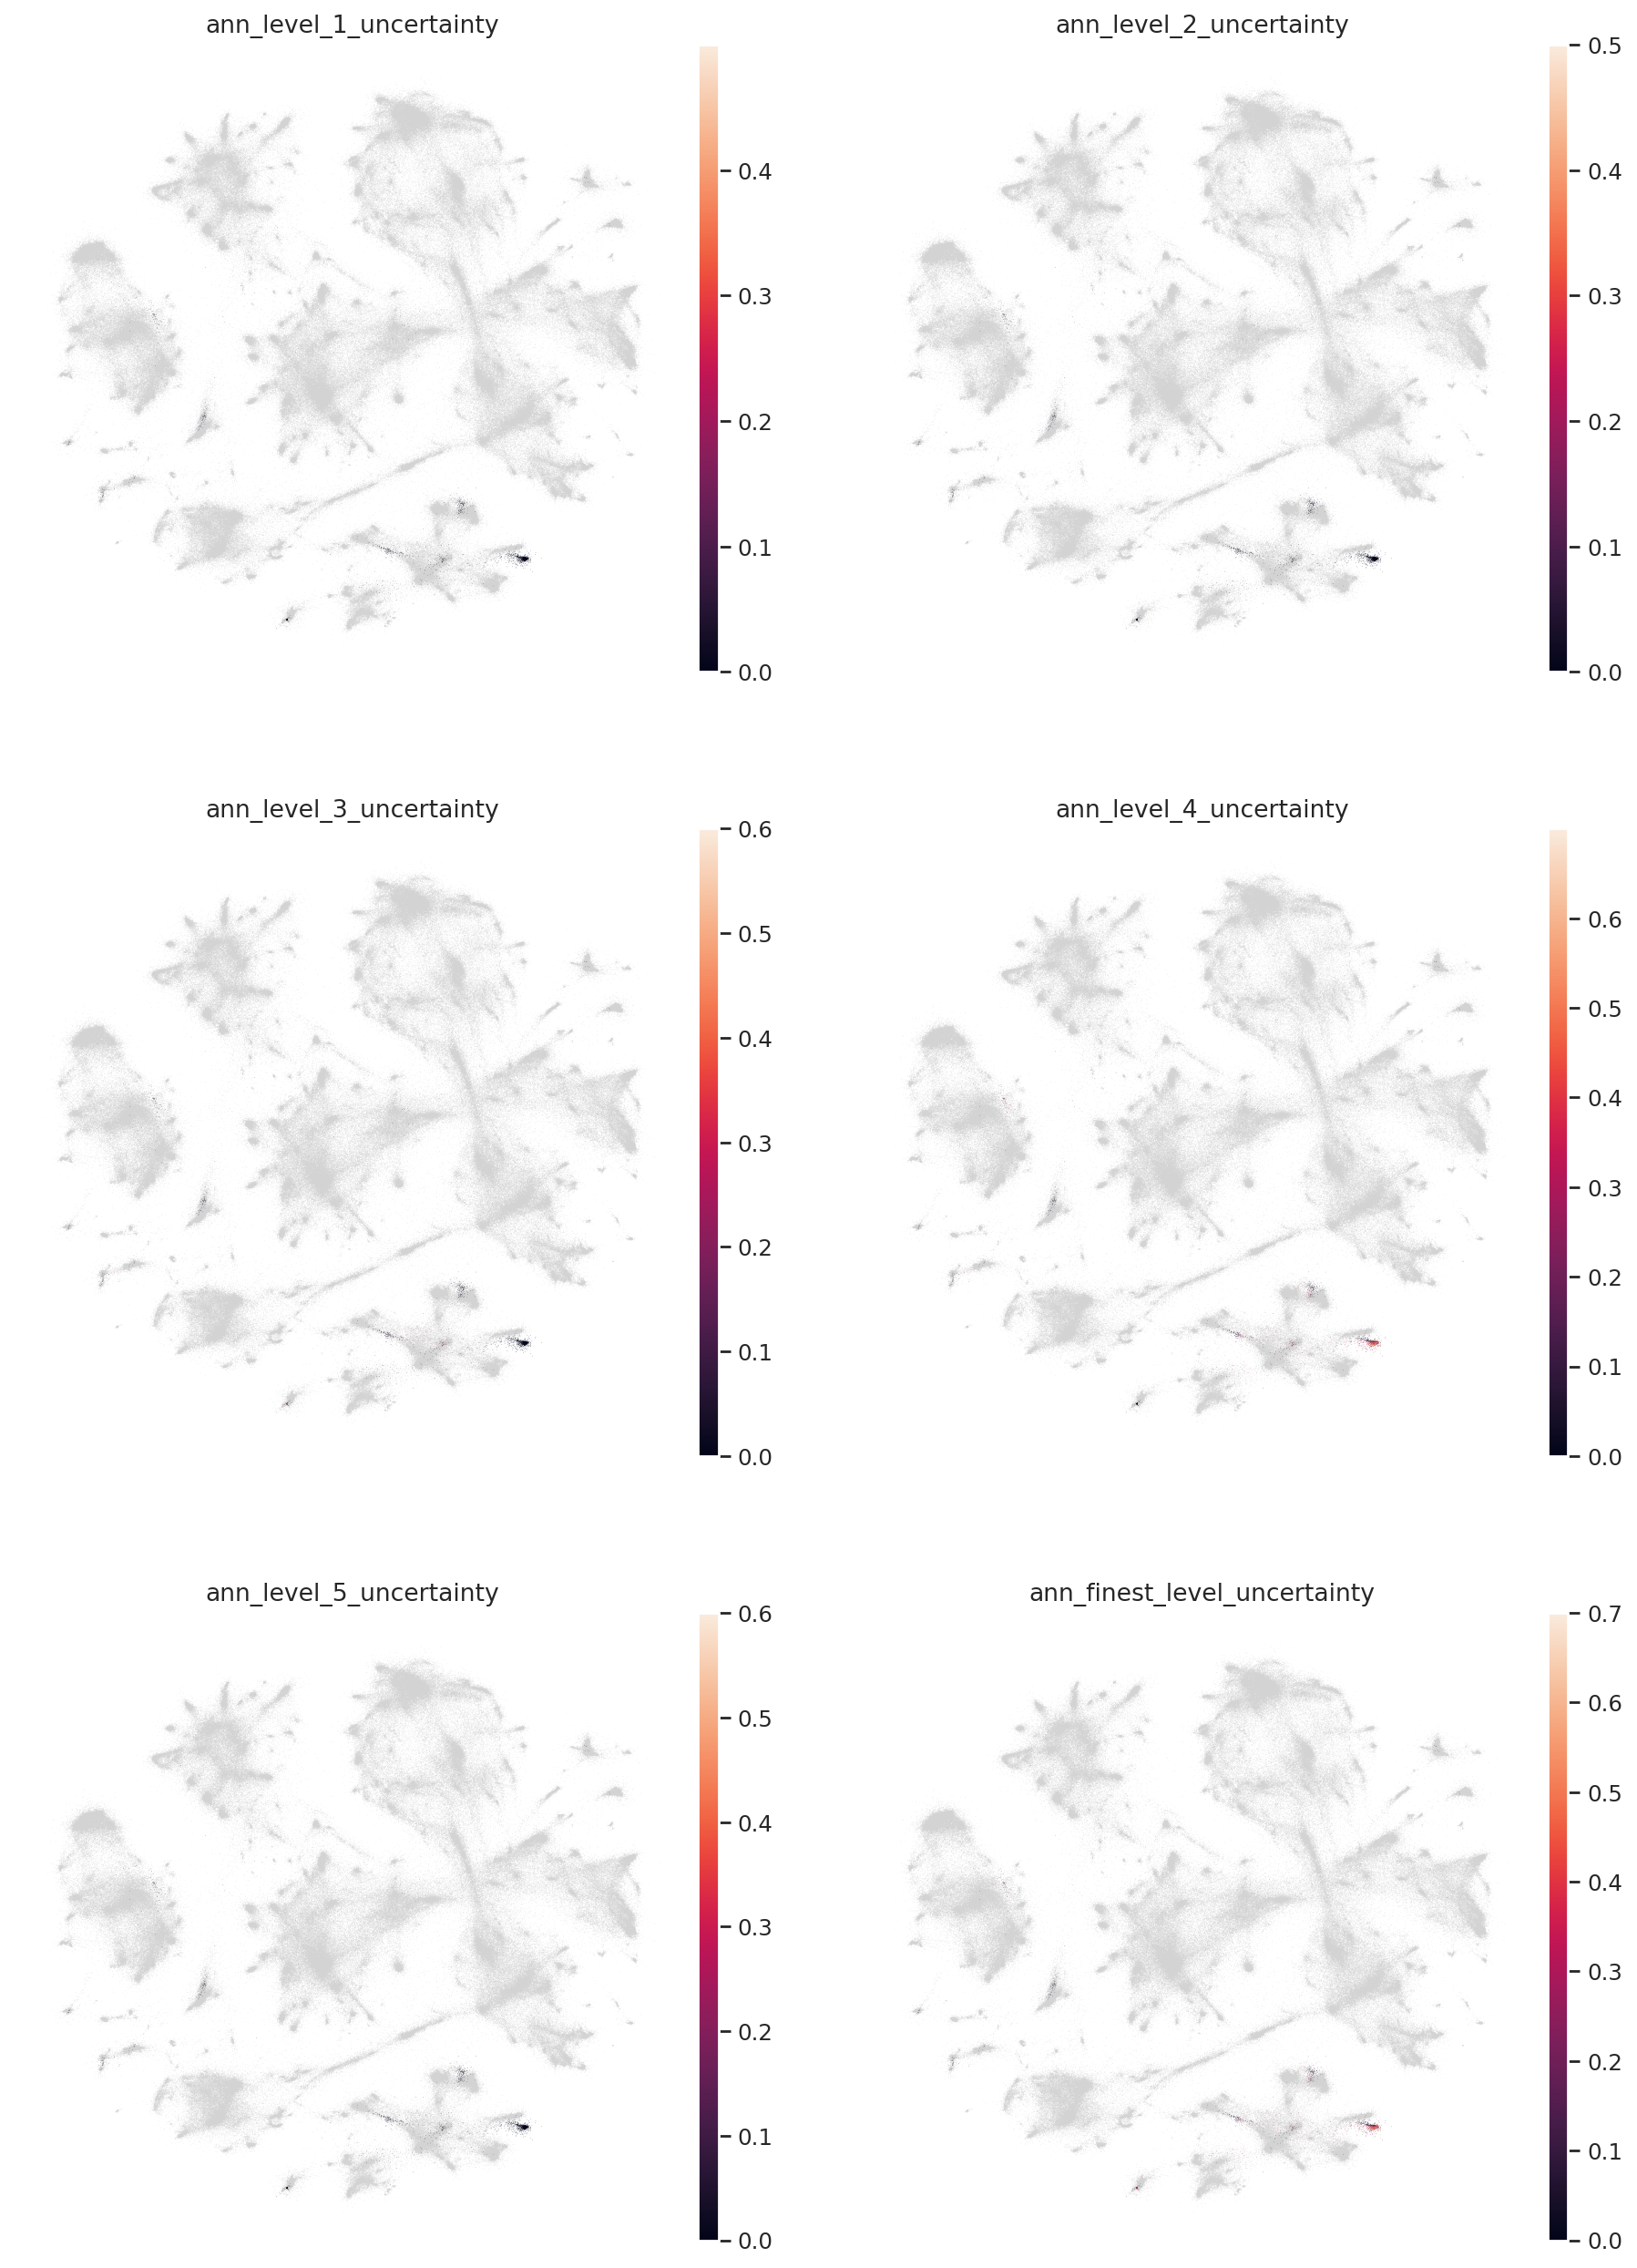

In [28]:
colors = [l + "_uncertainty" for l in label_keys]
sc.pl.embedding(
    combined_emb,
    basis=MDE_KEY,
    color=colors,
    ncols=2,
)

/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


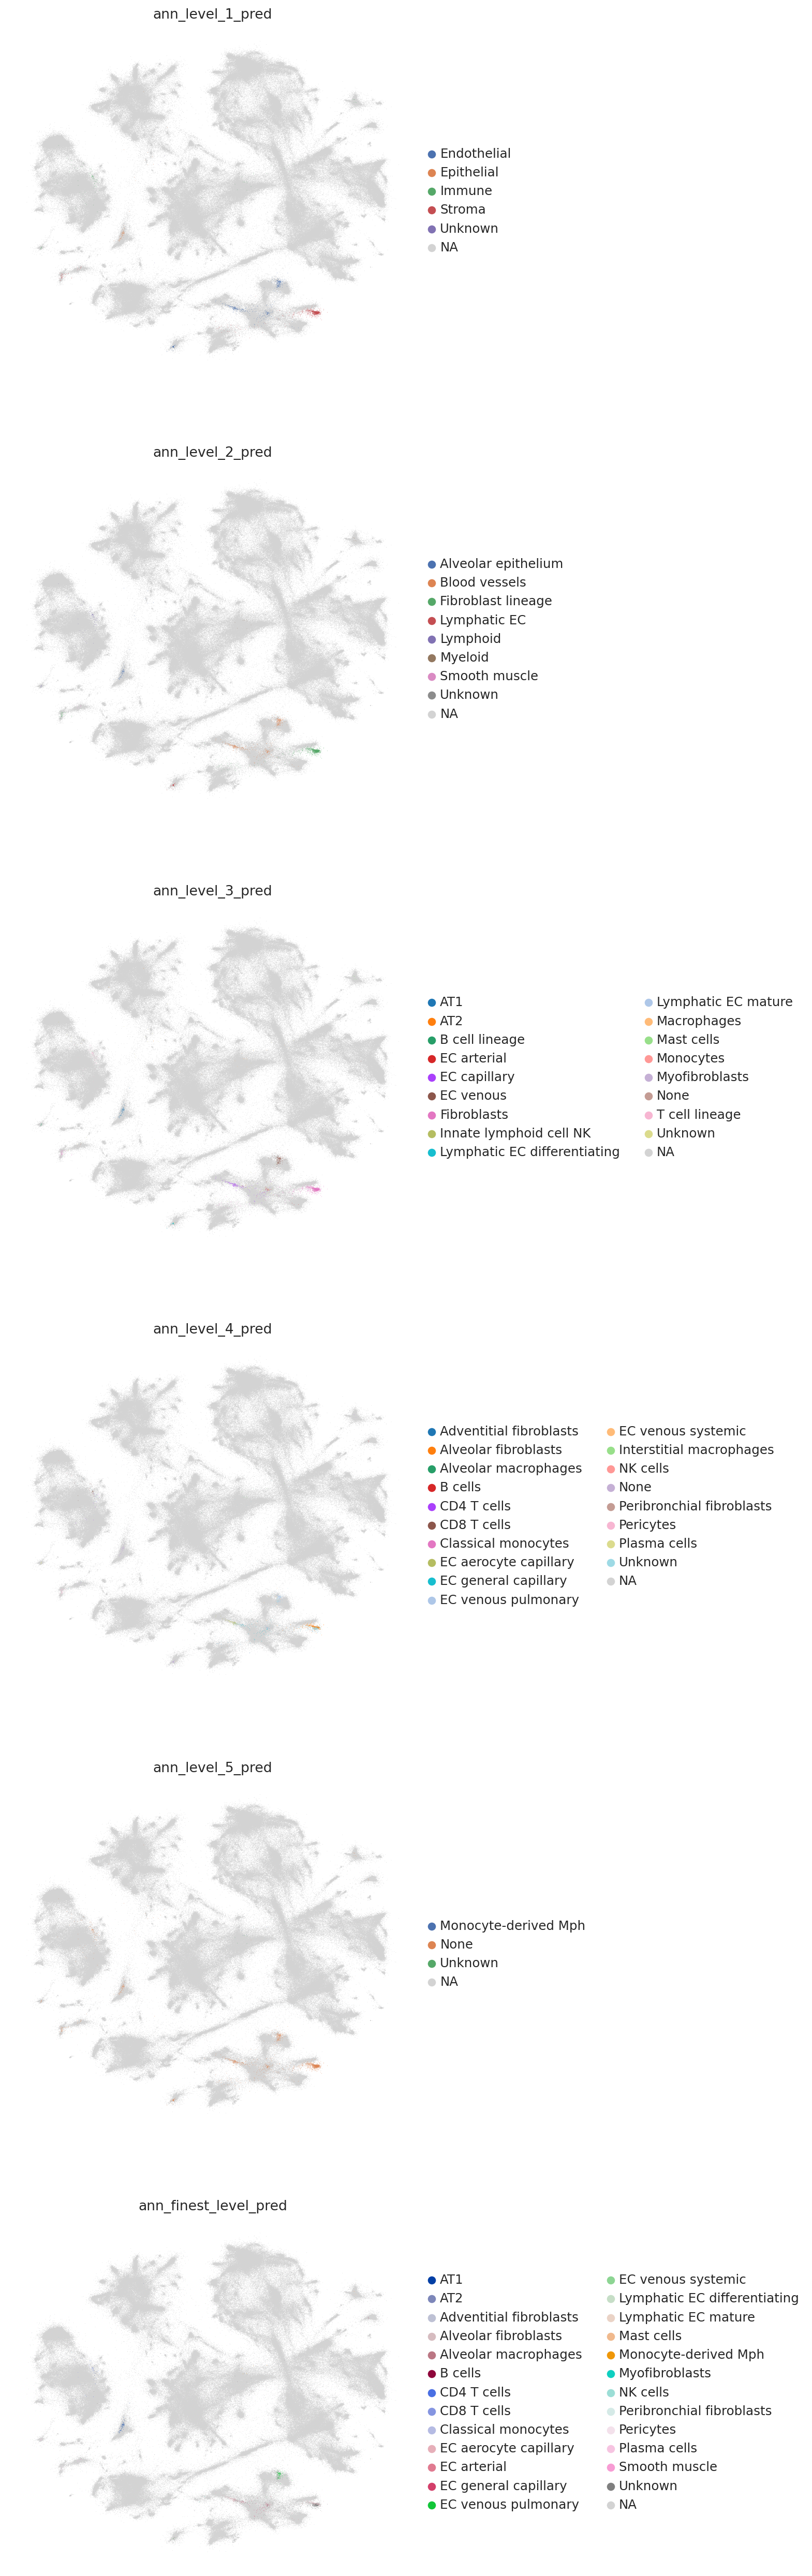

In [29]:
colors = [l + "_pred" for l in label_keys]

sc.pl.embedding(combined_emb, basis=MDE_KEY, color=colors, ncols=1, size=0.5)

/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


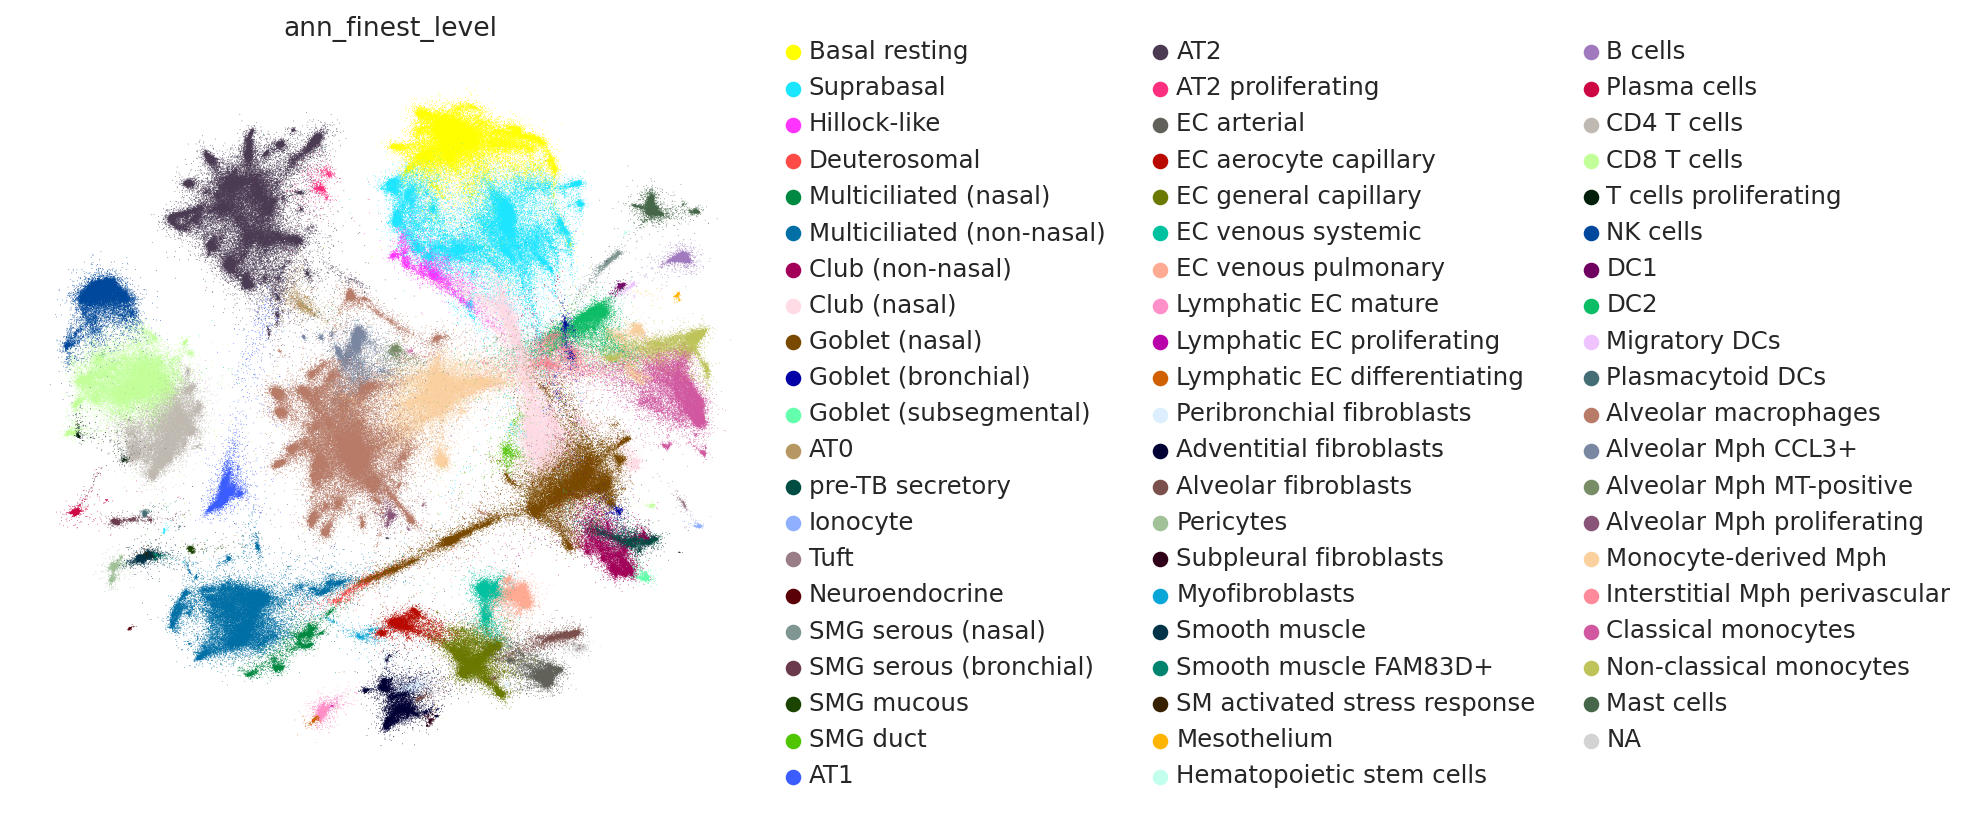

In [30]:
sc.pl.embedding(combined_emb, basis=MDE_KEY, color="ann_finest_level", ncols=1, size=0.5)